In [16]:
from util import longpath
from tqdm import tqdm
import os
import soundfile as sf
import librosa
import numpy as np
import scipy.signal
src_label_file = r"D:\MLP_Samples\AIData\Master file\Sliced Dialogue\Label files\fim_rainbow roadtrip.txt"
audio_source = r"D:\MLP_Samples\AIData\Master file\Sliced Dialogue\FiM\Rainbow Roadtrip"
src_audio = r"D:\MLP_Samples\AIData\for vul\Rainbow Roadtrip.flac"

#src_label_file = r"D:\MLP_Samples\AIData\Master file\Sliced Dialogue\Label files\fim_movie.txt"
#audio_source = r"D:\MEGASyncDownloads\Master file 2\MLP Movie (still has music, don't use this in any training)\MLP Movie"
#src_audio = r"D:\MLP_Samples\AIData\for vul\MLP Movie_C.flac"

audio_set = set(os.listdir(audio_source))

with open(src_label_file, 'r', encoding='utf-8') as f:
    lines = [{'ts': float(x[0]), 'te': float(x[1]), 'line': x[2]} for x in [line.split('\t') for line in f.readlines()]]

SEARCH_GAP = 90
DOWNSAMPLE_SR = 8000
ORIG_SR = 48000
CLIP_SAMPLE = 3 # Seconds of clip to identify
PULSE_STD = 200 # Windowing function used to "bias" cross-correlation.
start_idx = 0
end_idx = 0

print("Loading source audio")
src_data, src_sr = sf.read(src_audio, dtype='float32')
print("Resampling source audio")
src_8k = librosa.resample(src_data, orig_sr=ORIG_SR, target_sr=DOWNSAMPLE_SR)

# Operates off the assumption that audio clip order is invariant across
# different alignments.

N_CLIPS = 1600
for i,l in tqdm(enumerate(lines[0:N_CLIPS])):
    test_path = l['line'].strip().replace('?','_')+'.flac'
    if test_path not in audio_set:
        continue # The only time this path fails is for singing audios in Rainbow Roadtrip with the normal master file
        # So I just copied them back in so all alignments are accurate
    clip_data, clip_sr = sf.read(longpath(os.path.join(audio_source,test_path)), dtype='float32')

    # 1. To get a "coarse" alignment, we downsample both clips to 8khz (which is
    # enough to convey speech data). If there is an error of 1 sample then that is .000125 sec which is acceptable
    clip_8k = librosa.resample(clip_data, orig_sr=ORIG_SR, target_sr=DOWNSAMPLE_SR)
    clip_8k = clip_8k[:CLIP_SAMPLE*DOWNSAMPLE_SR]

    assert src_sr == ORIG_SR
    assert clip_sr == ORIG_SR

    # 2. Calculate cross-correlation using FFT method
    end_idx = start_idx + SEARCH_GAP*DOWNSAMPLE_SR
    src_8k_search_segment = src_8k[start_idx:end_idx]

    result_length = len(src_8k_search_segment) + len(clip_8k) - 1
    fft_src = np.fft.fft(src_8k_search_segment, n=result_length)
    fft_clip = np.fft.fft(clip_8k, n=result_length)
    cross_corr = np.fft.ifft(fft_src * np.conj(fft_clip)).real

    denom_src = np.sqrt(np.sum(np.abs(src_8k_search_segment)**2))
    denom_clip = np.sqrt(np.sum(np.abs(clip_8k)**2))
    ncc = cross_corr / (denom_src * denom_clip)

    alignment = np.argmax(np.absolute(cross_corr))
    
    # Window cross-correlation by expected offset from the START of the previous clip
    if i != 0:
        expected_offset = l['ts'] - lines[i-1]['ts']
        expected_offset_samples_8k = int(expected_offset * DOWNSAMPLE_SR)
        #print(f"Between {lines[i-1]['line']} and {l['line']}")

        window = scipy.signal.windows.gaussian(len(cross_corr), std=PULSE_STD)
        #print(expected_offset_samples_8k - len(cross_corr) // 2)
        window = np.roll(window, expected_offset_samples_8k - len(cross_corr) // 2)
        modified_corr = cross_corr * window

        old_alignment = alignment
        alignment = np.argmax(np.absolute(modified_corr))

        windowed_corr = modified_corr[alignment]
        print(f"Expected offset: {expected_offset_samples_8k} pre-window: {old_alignment} | {cross_corr[old_alignment]} post-window: {alignment} | {modified_corr[alignment]}")
        if abs(windowed_corr) < 0.5:
            if abs(cross_corr[old_alignment]) < 2.5:
                print(f"Warning - Could not find a plausible alignment for line {l['line']}; using post-window")
            else:
                print(f"Warning - windowed corr for line {l['line']} low; using pre-window")
                alignment = old_alignment

    l['alignment'] = start_idx + alignment
    l['cross_corr'] = cross_corr[alignment]

    start_idx = start_idx + alignment

for l in lines[0:N_CLIPS]:
    print(l['line'],l['alignment']/DOWNSAMPLE_SR,l['cross_corr'])
#print(f"Sample alignment for line {l['line']}: {alignment} ({alignment/DOWNSAMPLE_SR} sec)")

# Problem: I think the noise canceling knocks enough stuff out of wack that cross-correlation is not feasible



Loading source audio
Resampling source audio


2it [00:00,  2.26it/s]

Expected offset: 70991 pre-window: 70991 | -7.626435009211699 post-window: 70991 | -7.626411176639533


3it [00:01,  2.08it/s]

Expected offset: 10215 pre-window: 10215 | -7.166184550816595 post-window: 10215 | -7.166184550816595


4it [00:01,  2.13it/s]

Expected offset: 89237 pre-window: 89238 | -8.303382814888556 post-window: 89238 | -8.303149285530909


5it [00:02,  2.57it/s]

Expected offset: 31351 pre-window: 31351 | -3.049148360517004 post-window: 31351 | -3.049148360517004


6it [00:02,  2.33it/s]

Expected offset: 83840 pre-window: 83841 | -15.576067672021086 post-window: 83841 | -15.57587297239206


7it [00:03,  2.19it/s]

Expected offset: 14660 pre-window: 14660 | -17.847514076241744 post-window: 14660 | -17.847514076241744


8it [00:03,  2.20it/s]

Expected offset: 28737 pre-window: 28738 | -12.936795648897562 post-window: 28738 | -12.936633939962633


9it [00:03,  2.64it/s]

Expected offset: 19646 pre-window: 19646 | -17.03834166775212 post-window: 19646 | -17.03834166775212


10it [00:04,  3.00it/s]

Expected offset: 16679 pre-window: 16680 | -18.89806994687995 post-window: 16680 | -18.89783372248202


11it [00:04,  2.68it/s]

Expected offset: 17024 pre-window: 17024 | -29.434562649075854 post-window: 17024 | -29.434470666211297


12it [00:04,  2.51it/s]

Expected offset: 21110 pre-window: 21110 | -24.789259413375323 post-window: 21110 | -24.789259413375323


13it [00:05,  2.40it/s]

Expected offset: 21907 pre-window: 21908 | -40.50253760247305 post-window: 21908 | -40.502031323917265


14it [00:05,  2.34it/s]

Expected offset: 80853 pre-window: 80853 | -35.95080707086786 post-window: 80853 | -35.95080707086786


15it [00:06,  2.32it/s]

Expected offset: 34756 pre-window: 34757 | -5.463839546573757 post-window: 34757 | -5.463771249006285


16it [00:06,  2.27it/s]

Expected offset: 54737 pre-window: 54737 | -33.901120122534316 post-window: 54737 | -33.901120122534316


17it [00:07,  2.19it/s]

Expected offset: 29874 pre-window: 29875 | -39.060754890658515 post-window: 29875 | -39.06026663427399


18it [00:07,  2.12it/s]

Expected offset: 36704 pre-window: 36704 | -25.04499673041071 post-window: 36704 | -25.04499673041071


19it [00:08,  2.11it/s]

Expected offset: 33259 pre-window: 33259 | -28.565402215378757 post-window: 33259 | -28.565402215378757


20it [00:08,  2.08it/s]

Expected offset: 39382 pre-window: 39382 | -34.26690413995579 post-window: 39382 | -34.26690413995579


21it [00:09,  2.14it/s]

Expected offset: 30603 pre-window: 30604 | -20.453419027559463 post-window: 30604 | -20.453163361419534


22it [00:09,  2.18it/s]

Expected offset: 74952 pre-window: 74952 | -18.801597245598504 post-window: 74952 | -18.801597245598504


23it [00:10,  2.08it/s]

Expected offset: 13322 pre-window: 13323 | -38.23437829392714 post-window: 13323 | -38.23390036718552


24it [00:10,  2.06it/s]

Expected offset: 35040 pre-window: 35040 | -25.864920695316016 post-window: 35040 | -25.864920695316016


25it [00:11,  2.02it/s]

Expected offset: 38529 pre-window: 38529 | -19.81749685841783 post-window: 38529 | -19.81743492883691


26it [00:11,  2.04it/s]

Expected offset: 39214 pre-window: 39215 | -33.49196788429368 post-window: 39215 | -33.49154923731167


27it [00:12,  1.81it/s]

Expected offset: 27437 pre-window: 27437 | -21.106478862288807 post-window: 27437 | -21.106478862288807


28it [00:12,  1.91it/s]

Expected offset: 25893 pre-window: 25894 | -10.360965514400018 post-window: 25894 | -10.360836003140534


29it [00:13,  1.97it/s]

Expected offset: 13397 pre-window: 13397 | -27.069549137823692 post-window: 13397 | -27.069549137823692


30it [00:13,  2.01it/s]

Expected offset: 30367 pre-window: 30368 | -30.481956714971872 post-window: 30368 | -30.481575692894328


31it [00:14,  2.06it/s]

Expected offset: 27483 pre-window: 27483 | -11.776586205062694 post-window: 27483 | -11.776586205062694


32it [00:14,  2.08it/s]

Expected offset: 39916 pre-window: 39917 | -23.036696453623847 post-window: 39917 | -23.0360485556472


33it [00:15,  2.14it/s]

Expected offset: 49962 pre-window: 49963 | -9.677555097292625 post-window: 49963 | -9.677434128609965


34it [00:15,  2.15it/s]

Expected offset: 7516 pre-window: 7517 | -38.916286382819905 post-window: 7517 | -38.91579993228044


35it [00:16,  2.06it/s]

Expected offset: 244152 pre-window: 244152 | -49.15830282037817 post-window: 244152 | -49.15830282037817


36it [00:16,  2.08it/s]

Expected offset: 31332 pre-window: 31333 | -14.845608654164732 post-window: 31333 | -14.845423085216362


37it [00:17,  2.04it/s]

Expected offset: 8861 pre-window: 8861 | -39.682528536411084 post-window: 8861 | -39.682528536411084


38it [00:17,  2.02it/s]

Expected offset: 37221 pre-window: 37222 | -23.212441469971296 post-window: 37222 | -23.212151316266386


39it [00:17,  2.14it/s]

Expected offset: 28955 pre-window: 28955 | -25.149385013975493 post-window: 28955 | -25.149385013975493


40it [00:18,  2.15it/s]

Expected offset: 20756 pre-window: 20757 | -35.78008414268227 post-window: 20757 | -35.77963689442579


41it [00:19,  2.00it/s]

Expected offset: 28455 pre-window: 28456 | -21.748793594609566 post-window: 28456 | -21.74852173638875


42it [00:19,  1.99it/s]

Expected offset: 29809 pre-window: 29810 | -41.290646367056084 post-window: 29810 | -41.29013023720231


43it [00:19,  2.16it/s]

Expected offset: 47174 pre-window: 47174 | -37.18859887669108 post-window: 47174 | -37.18848266250117


44it [00:20,  2.16it/s]

Expected offset: 44696 pre-window: 44697 | -44.532200252991956 post-window: 44697 | -44.53164360396786


45it [00:20,  2.16it/s]

Expected offset: 78765 pre-window: 78765 | -42.151823773793566 post-window: 78765 | -42.151823773793566


46it [00:21,  2.12it/s]

Expected offset: 27111 pre-window: 27111 | -49.2060830422268 post-window: 27111 | -49.2060830422268


47it [00:21,  2.01it/s]

Expected offset: 38618 pre-window: 38619 | -34.559903605520994 post-window: 38619 | -34.559471609425906


48it [00:22,  1.96it/s]

Expected offset: 65399 pre-window: 65400 | -25.734556972639382 post-window: 65400 | -25.73423529268773


49it [00:22,  2.01it/s]

Expected offset: 76961 pre-window: 76961 | -32.10645862357771 post-window: 76961 | -32.10645862357771


50it [00:23,  2.03it/s]

Expected offset: 38150 pre-window: 38151 | -49.84865069513027 post-window: 38151 | -49.848027590890986


51it [00:23,  2.09it/s]

Expected offset: 39843 pre-window: 39843 | -30.09988399569562 post-window: 39843 | -30.099789933705104


52it [00:24,  2.09it/s]

Expected offset: 15540 pre-window: 15541 | -34.340151110700404 post-window: 15541 | -34.33972186149433


53it [00:24,  2.12it/s]

Expected offset: 30704 pre-window: 30704 | -19.40931270215266 post-window: 30704 | -19.40931270215266


54it [00:25,  2.39it/s]

Expected offset: 48838 pre-window: 48839 | -30.61799896875154 post-window: 48839 | -30.617137849640088


55it [00:25,  2.25it/s]

Expected offset: 28075 pre-window: 28075 | -29.73905483022025 post-window: 28075 | -29.73905483022025


56it [00:25,  2.22it/s]

Expected offset: 21393 pre-window: 21394 | -24.79078130764439 post-window: 21394 | -24.79008407672497


57it [00:26,  2.66it/s]

Expected offset: 13467 pre-window: 13468 | -35.851207302325555 post-window: 13468 | -35.85019900129948


58it [00:26,  2.50it/s]

Expected offset: 30797 pre-window: 30797 | -29.36745802836371 post-window: 30797 | -29.36745802836371


59it [00:27,  2.43it/s]

Expected offset: 44586 pre-window: 44586 | -45.15461920298618 post-window: 44586 | -45.15461920298618


60it [00:27,  2.47it/s]

Expected offset: 92513 pre-window: 92514 | -40.31868164438551 post-window: 92514 | -40.31754769741046


61it [00:27,  2.38it/s]

Expected offset: 27818 pre-window: 27818 | -41.92221634078443 post-window: 27818 | -41.92221634078443


62it [00:28,  2.49it/s]

Expected offset: 30508 pre-window: 30508 | -14.481652172871991 post-window: 30508 | -14.481652172871991


63it [00:28,  2.42it/s]

Expected offset: 14270 pre-window: 14271 | -29.997141813171204 post-window: 14271 | -29.9962981554217


64it [00:29,  2.18it/s]

Expected offset: 30441 pre-window: 30441 | -9.788453095713704 post-window: 30441 | -9.788453095713704


66it [00:29,  2.76it/s]

Expected offset: 15016 pre-window: 15017 | -27.77773702479123 post-window: 15017 | -27.777389805248546
Expected offset: 22643 pre-window: 22643 | -19.871607949347013 post-window: 22643 | -19.8715458506692


67it [00:30,  2.60it/s]

Expected offset: 14060 pre-window: 14061 | -46.00795088862132 post-window: 14061 | -46.00737579282957


68it [00:30,  2.55it/s]

Expected offset: 31360 pre-window: 31360 | -32.25269389416893 post-window: 31360 | -32.25269389416893


69it [00:31,  2.47it/s]

Expected offset: 45720 pre-window: 45720 | -26.941590927001 post-window: 45720 | -26.941590927001


70it [00:31,  2.38it/s]

Expected offset: 35615 pre-window: 35616 | -30.035860343321474 post-window: 35616 | -30.035484897413724


71it [00:32,  2.33it/s]

Expected offset: 23642 pre-window: 23642 | -15.930973255074747 post-window: 23642 | -15.930923470861112


72it [00:32,  2.30it/s]

Expected offset: 13106 pre-window: 13106 | -34.48264338088168 post-window: 13106 | -34.48253562278949


73it [00:32,  2.40it/s]

Expected offset: 21059 pre-window: 21060 | -22.297299388212068 post-window: 21060 | -22.297020673711682


74it [00:33,  2.10it/s]

Expected offset: 49384 pre-window: 49384 | -26.62649723678623 post-window: 49384 | -26.62649723678623


75it [00:33,  2.16it/s]

Expected offset: 24023 pre-window: 24024 | -28.92861571980606 post-window: 24024 | -28.92780211393033


76it [00:34,  2.16it/s]

Expected offset: 20688 pre-window: 20688 | -24.697657032471803 post-window: 20688 | -24.697657032471803


77it [00:35,  1.98it/s]

Expected offset: 63768 pre-window: 63768 | -20.333736856165864 post-window: 63768 | -20.333673313337474


78it [00:35,  1.96it/s]

Expected offset: 15418 pre-window: 15419 | -39.5185943330274 post-window: 15419 | -39.51810035368562


79it [00:36,  1.97it/s]

Expected offset: 53940 pre-window: 53941 | -17.23514738050146 post-window: 53941 | -17.234931942505693


80it [00:36,  1.96it/s]

Expected offset: 52000 pre-window: 52000 | -15.954448109633255 post-window: 52000 | -15.954398252060814


81it [00:37,  1.95it/s]

Expected offset: 103499 pre-window: 140507 | -16.191762102299528 post-window: 103574 | -0.2435680615088863
Warning - windowed corr for line 00_07_09_Twilight_Anxious Shouting_Very Noisy_Rainbow dash, fluttershy! Let's get everypony out!
 low; using pre-window


82it [00:37,  1.95it/s]

Expected offset: 165492 pre-window: 165492 | -24.14392841778746 post-window: 165492 | -24.14392841778746


83it [00:38,  1.94it/s]

Expected offset: 31695 pre-window: 31696 | -18.09630263895351 post-window: 31696 | -18.09607643658429


84it [00:38,  1.97it/s]

Expected offset: 41805 pre-window: 41806 | -29.248136911021124 post-window: 41806 | -29.247771311594736


85it [00:39,  2.00it/s]

Expected offset: 46282 pre-window: 46282 | -12.10866544345667 post-window: 46282 | -12.108627603936284


86it [00:39,  2.07it/s]

Expected offset: 12244 pre-window: 12245 | -2.8905997626455586 post-window: 12245 | -2.8905636303743525


87it [00:40,  2.06it/s]

Expected offset: 10857 pre-window: 10858 | -18.97071388638904 post-window: 10858 | -18.97047675394754


88it [00:40,  2.03it/s]

Expected offset: 19609 pre-window: 19609 | -32.142534670051134 post-window: 19609 | -32.142534670051134


89it [00:41,  1.98it/s]

Expected offset: 42375 pre-window: 42376 | -29.878734638677802 post-window: 42376 | -29.878361156829083


90it [00:41,  2.28it/s]

Expected offset: 49095 pre-window: 49095 | -30.597335445102424 post-window: 49095 | -30.59723982857856


91it [00:41,  2.18it/s]

Expected offset: 36170 pre-window: 36171 | -20.83409493425423 post-window: 36171 | -20.83383450969521
Expected offset: 26404 pre-window: 26405 | -12.721876340201561 post-window: 26405 | -12.721518542461048


93it [00:42,  2.44it/s]

Expected offset: 196633 pre-window: 196633 | -29.201468664030667 post-window: 196633 | -29.201468664030667


94it [00:43,  2.27it/s]

Expected offset: 51418 pre-window: 51419 | -8.927149977394503 post-window: 51419 | -8.927038388717216


95it [00:43,  2.46it/s]

Expected offset: 11114 pre-window: 11114 | -16.660939815707465 post-window: 11114 | -16.660887750351893


96it [00:43,  2.26it/s]

Expected offset: 27882 pre-window: 27883 | -23.963764439172287 post-window: 27883 | -23.963090467775203


97it [00:44,  2.24it/s]

Expected offset: 70927 pre-window: 70927 | -46.56196141145589 post-window: 70927 | -46.56196141145589


98it [00:44,  2.28it/s]

Expected offset: 27513 pre-window: 27513 | -25.196688936786515 post-window: 27513 | -25.196688936786515


99it [00:45,  2.22it/s]

Expected offset: 21351 pre-window: 21352 | -41.00881117394155 post-window: 21352 | -41.008298567005674


100it [00:45,  2.20it/s]

Expected offset: 71408 pre-window: 71408 | -38.427749460813374 post-window: 71408 | -38.427749460813374


101it [00:46,  2.24it/s]

Expected offset: 30896 pre-window: 30897 | -13.036811975829735 post-window: 30897 | -13.036445320649028


102it [00:46,  2.25it/s]

Expected offset: 22357 pre-window: 22357 | -25.77366086392017 post-window: 22357 | -25.77358032135582


103it [00:47,  2.27it/s]

Expected offset: 19402 pre-window: 19403 | -32.238728159256674 post-window: 19403 | -32.238325177673325


104it [00:47,  2.27it/s]

Expected offset: 23192 pre-window: 23192 | -41.49706644452038 post-window: 23192 | -41.49706644452038


105it [00:47,  2.28it/s]

Expected offset: 49212 pre-window: 49212 | -33.71466491632857 post-window: 49212 | -33.71466491632857


106it [00:48,  2.65it/s]

Expected offset: 66819 pre-window: 66819 | -41.54808013009557 post-window: 66819 | -41.54795029254803


107it [00:48,  2.60it/s]

Expected offset: 28649 pre-window: 28650 | -35.743030391219655 post-window: 28650 | -35.74202513262642


108it [00:48,  2.44it/s]

Expected offset: 22100 pre-window: 22101 | -24.731762057380674 post-window: 22101 | -24.731452912287118


109it [00:49,  2.49it/s]

Expected offset: 17985 pre-window: 17985 | -32.720539812343524 post-window: 17985 | -32.720539812343524


110it [00:49,  2.37it/s]

Expected offset: 26024 pre-window: 26024 | -13.8612736492756 post-window: 26024 | -13.861230332863126


111it [00:50,  2.33it/s]

Expected offset: 54414 pre-window: 54415 | -33.62609337976277 post-window: 54415 | -33.62567305622255


112it [00:50,  2.36it/s]

Expected offset: 40828 pre-window: 40828 | -34.431368369329796 post-window: 40828 | -34.43126077147176


113it [00:51,  2.35it/s]

Expected offset: 40892 pre-window: 40892 | -17.503808234334187 post-window: 40892 | -17.503808234334187


114it [00:51,  2.29it/s]

Expected offset: 18053 pre-window: 18053 | -20.595206886559815 post-window: 18053 | -20.595206886559815


115it [00:52,  2.30it/s]

Expected offset: 22357 pre-window: 22358 | -22.502864957155186 post-window: 22358 | -22.50258367310125


116it [00:52,  2.30it/s]

Expected offset: 11178 pre-window: 11179 | -34.171378513539565 post-window: 11179 | -34.17095137397777


117it [00:52,  2.22it/s]

Expected offset: 23155 pre-window: 23155 | -25.825305521108596 post-window: 23155 | -25.825305521108596


118it [00:53,  2.22it/s]

Expected offset: 51690 pre-window: 51691 | -39.25289176271511 post-window: 51691 | -39.25240110463469


119it [00:53,  2.59it/s]

Expected offset: 45678 pre-window: 45678 | -17.943528508343544 post-window: 45678 | -17.943528508343544


120it [00:54,  2.50it/s]

Expected offset: 14840 pre-window: 14841 | -14.159100165286365 post-window: 14841 | -14.158923177640473


121it [00:54,  2.38it/s]

Expected offset: 13910 pre-window: 13910 | -30.52819133852918 post-window: 13910 | -30.52819133852918


122it [00:55,  2.28it/s]

Expected offset: 76868 pre-window: 76869 | -46.30660637485839 post-window: 76869 | -46.30602754589639


123it [00:55,  2.22it/s]

Expected offset: 110470 pre-window: 110470 | -19.425814462195593 post-window: 110470 | -19.425814462195593


124it [00:55,  2.25it/s]

Expected offset: 18566 pre-window: 18567 | -15.004745956008918 post-window: 18567 | -15.004323953463345


125it [00:56,  2.20it/s]

Expected offset: 13716 pre-window: 13717 | -35.09225776288637 post-window: 13717 | -35.0918191124059


126it [00:56,  2.10it/s]

Expected offset: 48313 pre-window: 48313 | -12.068007845092595 post-window: 48313 | -12.067970132627003


127it [00:57,  2.07it/s]

Expected offset: 12334 pre-window: 12335 | -20.922101569102704 post-window: 12335 | -20.921840044467622


128it [00:57,  2.18it/s]

Expected offset: 34307 pre-window: 34307 | -12.721139000843234 post-window: 34307 | -12.721139000843234


129it [00:58,  2.04it/s]

Expected offset: 31223 pre-window: 31223 | -21.071009121833086 post-window: 31223 | -21.071009121833086


130it [00:58,  2.06it/s]

Expected offset: 18231 pre-window: 18231 | -38.24241546478021 post-window: 18231 | -38.24229595741861


132it [00:59,  2.63it/s]

Expected offset: 31696 pre-window: 31696 | -10.808013053715856 post-window: 31696 | -10.808013053715856
Expected offset: 34491 pre-window: 34492 | -17.765846905860894 post-window: 34492 | -17.76534724844313


133it [00:59,  2.44it/s]

Expected offset: 26236 pre-window: 26236 | -40.7378737798692 post-window: 26236 | -40.7378737798692


134it [01:00,  2.24it/s]

Expected offset: 28629 pre-window: 28629 | -34.958334065982335 post-window: 28629 | -34.958334065982335


135it [01:00,  2.22it/s]

Expected offset: 42106 pre-window: 42107 | -26.415442702578268 post-window: 42107 | -26.415112511608182


136it [01:01,  2.23it/s]

Expected offset: 45384 pre-window: 45384 | -17.74389323994902 post-window: 45384 | -17.743837790369284


137it [01:01,  2.21it/s]

Expected offset: 15015 pre-window: 15016 | -21.884079229627933 post-window: 15016 | -21.883463748554842


138it [01:02,  2.18it/s]

Expected offset: 40054 pre-window: 40054 | -20.874535637511865 post-window: 40054 | -20.874535637511865


139it [01:02,  2.09it/s]

Expected offset: 20001 pre-window: 20002 | -13.12278345946254 post-window: 20002 | -13.12261942569451


140it [01:03,  2.12it/s]

Expected offset: 28214 pre-window: 28215 | -16.923652497138107 post-window: 28215 | -16.923176526105


141it [01:03,  2.10it/s]

Expected offset: 17539 pre-window: 17539 | -33.96773196258731 post-window: 17539 | -33.96773196258731


142it [01:04,  2.14it/s]

Expected offset: 21318 pre-window: 21318 | -13.933318781644935 post-window: 21318 | -13.933275240091776


143it [01:04,  2.13it/s]

Expected offset: 67308 pre-window: 67309 | -27.325308477241013 post-window: 67309 | -27.32496691301983


144it [01:05,  1.89it/s]

Expected offset: 44329 pre-window: 44329 | -27.13967746678481 post-window: 44329 | -27.13967746678481


145it [01:05,  1.93it/s]

Expected offset: 18818 pre-window: 18818 | -25.21635193965516 post-window: 18818 | -25.21635193965516


146it [01:06,  2.36it/s]

Expected offset: 125639 pre-window: 125640 | -25.854582904390373 post-window: 125640 | -25.85425972412395


147it [01:06,  2.64it/s]

Expected offset: 21070 pre-window: 21071 | -13.11187087008871 post-window: 21071 | -13.111706972727195


148it [01:06,  2.48it/s]

Expected offset: 19402 pre-window: 19402 | -20.520103717070135 post-window: 19402 | -20.520103717070135


149it [01:07,  2.40it/s]

Expected offset: 58397 pre-window: 58398 | -22.688903180846427 post-window: 58398 | -22.688265064418022


150it [01:07,  2.32it/s]

Expected offset: 23290 pre-window: 23290 | -29.445380108901645 post-window: 23290 | -29.445380108901645


151it [01:08,  2.28it/s]

Expected offset: 19471 pre-window: 19471 | -32.101517544045855 post-window: 19471 | -32.101517544045855


152it [01:08,  2.25it/s]

Expected offset: 28905 pre-window: 28906 | -41.90526589577057 post-window: 28906 | -41.904742083220704


153it [01:09,  2.26it/s]

Expected offset: 43173 pre-window: 43173 | -13.634051002900234 post-window: 43173 | -13.634051002900234


154it [01:09,  2.23it/s]

Expected offset: 11564 pre-window: 11564 | -7.856229906953011 post-window: 11564 | -7.856229906953011


155it [01:09,  2.26it/s]

Expected offset: 7837 pre-window: 7838 | -14.080209047106596 post-window: 7838 | -14.080033045593519


156it [01:10,  2.23it/s]

Expected offset: 19594 pre-window: 19595 | -14.162273675034632 post-window: 19595 | -14.162096647720116


157it [01:10,  2.17it/s]

Expected offset: 16896 pre-window: 16897 | -15.8525868761139 post-window: 16897 | -15.852388720016426


158it [01:11,  2.19it/s]

Expected offset: 16446 pre-window: 16447 | -37.69227402184272 post-window: 16447 | -37.69180287136214


159it [01:11,  2.13it/s]

Expected offset: 37455 pre-window: 37455 | -20.816238192692563 post-window: 37455 | -20.816238192692563


161it [01:12,  2.57it/s]

Expected offset: 15989 pre-window: 15989 | -16.076859085085534 post-window: 15989 | -16.076808844979393
Expected offset: 21023 pre-window: 21024 | -37.209055868529866 post-window: 21024 | -37.208009378549896


162it [01:12,  2.48it/s]

Expected offset: 22092 pre-window: 22093 | -33.32549269077041 post-window: 22093 | -33.324555424468855


163it [01:13,  2.35it/s]

Expected offset: 47971 pre-window: 47971 | -33.084146013888926 post-window: 47971 | -33.084146013888926


164it [01:13,  2.69it/s]

Expected offset: 36639 pre-window: 36640 | -32.020658446274396 post-window: 36640 | -32.0197578779199


165it [01:14,  2.41it/s]

Expected offset: 15744 pre-window: 15744 | -4.240508922162384 post-window: 15744 | -4.240508922162384


166it [01:14,  2.31it/s]

Expected offset: 17406 pre-window: 17407 | -18.5154279060429 post-window: 17407 | -18.515196464640585


167it [01:14,  2.59it/s]

Expected offset: 15961 pre-window: 15961 | -13.258952362046143 post-window: 15961 | -13.258952362046143


168it [01:15,  2.44it/s]

Expected offset: 10637 pre-window: 10638 | -18.35319464603806 post-window: 10638 | -18.352678469697402


169it [01:16,  2.19it/s]

Expected offset: 282322 pre-window: 282322 | -12.231937770632888 post-window: 282322 | -12.231937770632888


170it [01:16,  1.99it/s]

Expected offset: 27695 pre-window: 27696 | -47.466708218209185 post-window: 27696 | -47.46611488806478


171it [01:17,  1.95it/s]

Expected offset: 34143 pre-window: 34144 | -38.58886605863534 post-window: 34144 | -38.58778076203949


172it [01:17,  2.02it/s]

Expected offset: 19916 pre-window: 19916 | -20.302642286808005 post-window: 19916 | -20.30257884114999


173it [01:18,  2.08it/s]

Expected offset: 11628 pre-window: 11629 | -22.850025949465945 post-window: 11629 | -22.849740325926728


174it [01:18,  2.13it/s]

Expected offset: 18374 pre-window: 18374 | -53.69139113822841 post-window: 18374 | -53.69122335289327


175it [01:18,  2.16it/s]

Expected offset: 33057 pre-window: 33057 | -20.263195106105815 post-window: 33057 | -20.263195106105815


176it [01:19,  2.15it/s]

Expected offset: 92423 pre-window: 92424 | -42.78745137937173 post-window: 92424 | -42.786916539572246


177it [01:19,  2.17it/s]

Expected offset: 67063 pre-window: 67064 | -27.015706359508272 post-window: 67064 | -27.01536866528937


178it [01:20,  2.11it/s]

Expected offset: 42039 pre-window: 42040 | -25.919189102862163 post-window: 42040 | -25.918865115023305


179it [01:20,  2.15it/s]

Expected offset: 62736 pre-window: 62736 | -46.89209622139682 post-window: 62736 | -46.89209622139682


181it [01:21,  2.84it/s]

Expected offset: 57314 pre-window: 57314 | -17.00183355707215 post-window: 57314 | -17.00183355707215
Expected offset: 22164 pre-window: 22165 | -15.898510896354413 post-window: 22165 | -15.89806375702338


182it [01:21,  2.46it/s]

Expected offset: 15617 pre-window: 15617 | -32.879358283616355 post-window: 15617 | -32.879358283616355


183it [01:22,  2.34it/s]

Expected offset: 55952 pre-window: 55953 | -37.54552438983659 post-window: 55953 | -37.54505507371494


184it [01:22,  2.27it/s]

Expected offset: 34799 pre-window: 34799 | -27.141212929237167 post-window: 34799 | -27.141212929237167


185it [01:23,  2.24it/s]

Expected offset: 30345 pre-window: 30346 | -29.977336538054338 post-window: 30346 | -29.97696182368958


186it [01:23,  2.25it/s]

Expected offset: 47477 pre-window: 47477 | -45.90693473021394 post-window: 47477 | -45.90693473021394


187it [01:24,  2.21it/s]

Expected offset: 34949 pre-window: 34950 | -41.55447258869812 post-window: 34950 | -41.553953161037185


188it [01:24,  2.18it/s]

Expected offset: 60326 pre-window: 60327 | -32.89251827946081 post-window: 60327 | -32.89210712555203


189it [01:25,  2.14it/s]

Expected offset: 36108 pre-window: 36108 | -44.21559409453978 post-window: 36108 | -44.21559409453978


190it [01:25,  2.18it/s]

Expected offset: 27944 pre-window: 27944 | -28.647350797663165 post-window: 27944 | -28.647261274831802


191it [01:26,  2.20it/s]

Expected offset: 17439 pre-window: 17440 | -19.284789186390615 post-window: 17440 | -19.28424680932196


192it [01:26,  2.20it/s]

Expected offset: 17344 pre-window: 17344 | -21.518152114650963 post-window: 17344 | -21.51808487053067


193it [01:26,  2.23it/s]

Expected offset: 20017 pre-window: 20018 | -36.834185970888925 post-window: 20018 | -36.83372554644195


194it [01:27,  2.27it/s]

Expected offset: 33374 pre-window: 33374 | -33.14816050457898 post-window: 33374 | -33.14805691673926


195it [01:27,  2.12it/s]

Expected offset: 19435 pre-window: 19436 | -38.55362916514579 post-window: 19436 | -38.55314724779322


196it [01:28,  2.12it/s]

Expected offset: 29295 pre-window: 29296 | -16.778686014757415 post-window: 29296 | -16.77821412084929


197it [01:28,  2.15it/s]

Expected offset: 17282 pre-window: 17282 | -16.455087057948006 post-window: 17282 | -16.455035635881295


198it [01:29,  2.16it/s]

Expected offset: 16511 pre-window: 16511 | -42.025418097605794 post-window: 16511 | -42.025418097605794


199it [01:29,  2.20it/s]

Expected offset: 51611 pre-window: 51611 | -36.99675650160333 post-window: 51611 | -36.99675650160333


200it [01:30,  2.22it/s]

Expected offset: 33695 pre-window: 33696 | -32.023204119197786 post-window: 33696 | -32.0228038316481


201it [01:30,  2.16it/s]

Expected offset: 44083 pre-window: 44083 | -38.33052496876149 post-window: 44083 | -38.33052496876149


202it [01:31,  2.03it/s]

Expected offset: 138384 pre-window: 175222 | -36.598573826592464 post-window: 138366 | 0.16508914394504368
Warning - windowed corr for line 00_16_51_Mayor Sunny Skies_Happy_Very Noisy_Here is our famous outdoor spa With the all-natural mud bath. pretty huh?
 low; using pre-window


203it [01:31,  1.95it/s]

Expected offset: 68550 pre-window: 68550 | -41.35239538225893 post-window: 68550 | -41.35239538225893


204it [01:32,  1.91it/s]

Expected offset: 33407 pre-window: 33408 | -30.21608748920025 post-window: 33408 | -30.215709790467255


205it [01:32,  1.88it/s]

Expected offset: 45238 pre-window: 45238 | -42.95281342637861 post-window: 45238 | -42.95281342637861


206it [01:33,  1.88it/s]

Expected offset: 39703 pre-window: 39704 | -23.14768031591779 post-window: 39704 | -23.147390971722245


207it [01:33,  2.18it/s]

Expected offset: 21255 pre-window: 21256 | -33.7481438789975 post-window: 21256 | -33.74719472579844


208it [01:34,  1.85it/s]

Expected offset: 52152 pre-window: 52152 | -16.26376110006951 post-window: 52152 | -16.26376110006951


209it [01:34,  1.84it/s]

Expected offset: 27023 pre-window: 27024 | -53.705083662768054 post-window: 27024 | -53.70441235341796


210it [01:35,  1.81it/s]

Expected offset: 30105 pre-window: 30106 | -30.138958401197105 post-window: 30106 | -30.138581666571685


211it [01:36,  1.81it/s]

Expected offset: 54544 pre-window: 54544 | -47.8732960375524 post-window: 54544 | -47.8732960375524


212it [01:36,  1.82it/s]

Expected offset: 33471 pre-window: 33472 | -26.037276895900057 post-window: 33472 | -26.03654460778521


213it [01:37,  1.80it/s]

Expected offset: 18759 pre-window: 18760 | -25.578529895739937 post-window: 18760 | -25.578210166114555


214it [01:37,  1.81it/s]

Expected offset: 17942 pre-window: 17942 | -49.43839898236564 post-window: 17942 | -49.43839898236564


215it [01:38,  1.81it/s]

Expected offset: 54719 pre-window: 54719 | -17.678031045552654 post-window: 54719 | -17.678031045552654


216it [01:38,  1.81it/s]

Expected offset: 36041 pre-window: 36042 | -16.498944286189513 post-window: 36042 | -16.498480259906863


217it [01:39,  1.81it/s]

Expected offset: 91485 pre-window: 91486 | -36.654325409375744 post-window: 91486 | -36.65386723317173


218it [01:39,  1.83it/s]

Expected offset: 69256 pre-window: 69257 | -8.273780036417845 post-window: 69257 | -8.273676614813777


219it [01:40,  1.91it/s]

Expected offset: 44456 pre-window: 44456 | -15.997909174414698 post-window: 44456 | -15.997859181026643


220it [01:40,  1.89it/s]

Expected offset: 37703 pre-window: 37704 | -40.559909394988125 post-window: 37704 | -40.55940239928942


221it [01:41,  2.30it/s]

Expected offset: 26800 pre-window: 26800 | -30.42150611911103 post-window: 26800 | -30.42141105205295


222it [01:41,  2.14it/s]

Expected offset: 63295 pre-window: 63296 | -27.354447276283736 post-window: 63296 | -27.35410534782984


223it [01:42,  2.06it/s]

Expected offset: 61469 pre-window: 61469 | -43.11263601327869 post-window: 61469 | -43.11263601327869


224it [01:42,  1.90it/s]

Expected offset: 37712 pre-window: 37712 | -43.65111925454375 post-window: 37712 | -43.65111925454375


225it [01:43,  1.91it/s]

Expected offset: 33946 pre-window: 33947 | -10.680901936911829 post-window: 33947 | -10.680601540769194


226it [01:43,  1.89it/s]

Expected offset: 13679 pre-window: 13680 | -26.571687801799566 post-window: 13680 | -26.571355657777946


227it [01:44,  1.86it/s]

Expected offset: 32037 pre-window: 32038 | -36.53662014969736 post-window: 32038 | -36.536163444799904


228it [01:44,  1.86it/s]

Expected offset: 86410 pre-window: 86410 | -18.725794865355756 post-window: 86410 | -18.725794865355756


229it [01:45,  1.85it/s]

Expected offset: 19594 pre-window: 19595 | -3.173614406758853 post-window: 19595 | -3.173574736826706


230it [01:46,  1.87it/s]

Expected offset: 10548 pre-window: 10549 | -38.353206824213956 post-window: 10549 | -38.352727412124985


231it [01:46,  1.84it/s]

Expected offset: 43935 pre-window: 43936 | -27.468257175280527 post-window: 43936 | -27.467484641411282


232it [01:47,  1.86it/s]

Expected offset: 14964 pre-window: 14965 | -18.7464181467936 post-window: 14965 | -18.74589091119751


233it [01:47,  2.06it/s]

Expected offset: 12945 pre-window: 12945 | -24.64986225618733 post-window: 12945 | -24.64986225618733


234it [01:48,  1.94it/s]

Expected offset: 15290 pre-window: 15291 | -15.44604763161016 post-window: 15291 | -15.445613217629496


235it [01:48,  1.81it/s]

Expected offset: 15836 pre-window: 15836 | -28.6917760620039 post-window: 15836 | -28.6916864003438


236it [01:49,  1.83it/s]

Expected offset: 14764 pre-window: 14764 | -9.33239919703735 post-window: 14764 | -9.332370033335428


237it [01:49,  2.22it/s]

Expected offset: 8532 pre-window: 8533 | -19.845072232111978 post-window: 8533 | -19.84451409730426


238it [01:50,  2.08it/s]

Expected offset: 15635 pre-window: 15636 | -18.315432741121782 post-window: 15636 | -18.315203799643406


239it [01:50,  2.03it/s]

Expected offset: 9861 pre-window: 9862 | -25.303747911067664 post-window: 9862 | -25.303036253165402


240it [01:51,  1.98it/s]

Expected offset: 31304 pre-window: 31304 | -40.62906994045387 post-window: 31304 | -40.62906994045387


241it [01:51,  1.94it/s]

Expected offset: 60984 pre-window: 60984 | -35.67452958284392 post-window: 60984 | -35.67452958284392


242it [01:52,  1.93it/s]

Expected offset: 38161 pre-window: 38162 | -47.13127512674106 post-window: 38162 | -47.130685989484085


243it [01:52,  1.91it/s]

Expected offset: 70220 pre-window: 70221 | -49.699399983857624 post-window: 70221 | -49.698778745240574


244it [01:53,  1.88it/s]

Expected offset: 65145 pre-window: 65145 | -37.470286076994476 post-window: 65145 | -37.470286076994476


245it [01:53,  1.85it/s]

Expected offset: 63538 pre-window: 63539 | -26.88977032096278 post-window: 63539 | -26.88943420093452


246it [01:54,  1.85it/s]

Expected offset: 68550 pre-window: 68550 | -40.33551419918965 post-window: 68550 | -40.33551419918965


247it [01:54,  1.86it/s]

Expected offset: 65503 pre-window: 65504 | -32.96511785368631 post-window: 65504 | -32.96470579228853


248it [01:55,  1.85it/s]

Expected offset: 67400 pre-window: 67400 | -43.44885865784182 post-window: 67400 | -43.44885865784182


249it [01:55,  1.85it/s]

Expected offset: 67285 pre-window: 67286 | -58.22201269302398 post-window: 67286 | -58.221284922413886


250it [01:56,  1.85it/s]

Expected offset: 64514 pre-window: 64514 | -38.96158867157077 post-window: 64514 | -38.96158867157077


251it [01:57,  1.82it/s]

Expected offset: 102524 pre-window: 102524 | -52.445126303250156 post-window: 102524 | -52.445126303250156


252it [01:57,  1.81it/s]

Expected offset: 65273 pre-window: 65274 | -47.28405773634134 post-window: 65274 | -47.283466689313684


253it [01:58,  1.82it/s]

Expected offset: 64759 pre-window: 64759 | -39.30380338430216 post-window: 64759 | -39.30380338430216


254it [01:58,  1.83it/s]

Expected offset: 66402 pre-window: 66403 | -38.7866052160972 post-window: 66403 | -38.78612038656219


255it [01:59,  1.84it/s]

Expected offset: 42712 pre-window: 42712 | -61.43891535829299 post-window: 42712 | -61.43891535829299


256it [01:59,  1.84it/s]

Expected offset: 104439 pre-window: 104440 | -62.453948650374265 post-window: 104440 | -62.45316798089533


257it [02:00,  1.85it/s]

Expected offset: 67400 pre-window: 67400 | -67.23794769000712 post-window: 67400 | -67.23794769000712


258it [02:00,  1.83it/s]

Expected offset: 68541 pre-window: 68541 | -51.03710818715259 post-window: 68541 | -51.03710818715259


259it [02:01,  1.83it/s]

Expected offset: 67922 pre-window: 67923 | -49.25221505229497 post-window: 67923 | -49.25159940345463


260it [02:01,  1.86it/s]

Expected offset: 69735 pre-window: 69736 | -49.060599533142664 post-window: 69736 | -49.05998627948134


261it [02:02,  1.86it/s]

Expected offset: 58728 pre-window: 58728 | -52.76779156694223 post-window: 58728 | -52.76779156694223


262it [02:03,  1.84it/s]

Expected offset: 90087 pre-window: 90088 | -48.08965178349119 post-window: 90088 | -48.08905066660088


263it [02:03,  1.84it/s]

Expected offset: 196138 pre-window: 196137 | -39.14079784775872 post-window: 196137 | -39.14030859084348


264it [02:04,  1.84it/s]

Expected offset: 38765 pre-window: 38766 | -48.12773265174102 post-window: 38766 | -48.127131058842835


265it [02:04,  1.85it/s]

Expected offset: 40256 pre-window: 40256 | -35.87649878077196 post-window: 40256 | -35.87649878077196


266it [02:05,  1.85it/s]

Expected offset: 38159 pre-window: 38160 | -18.461412718675035 post-window: 38160 | -18.461181952458343


267it [02:05,  1.88it/s]

Expected offset: 21845 pre-window: 21846 | -21.80684762041092 post-window: 21846 | -21.806575036519316


269it [02:06,  2.37it/s]

Expected offset: 18438 pre-window: 18438 | -38.94050150863854 post-window: 18438 | -38.94050150863854
Expected offset: 61811 pre-window: 61812 | -28.96604479141141 post-window: 61812 | -28.96523013285784


270it [02:06,  2.22it/s]

Expected offset: 21024 pre-window: 21024 | -24.01698808475728 post-window: 21024 | -24.01698808475728


271it [02:07,  2.11it/s]

Expected offset: 21023 pre-window: 21024 | -48.183834033273094 post-window: 21024 | -48.183231739112024


272it [02:08,  2.03it/s]

Expected offset: 33304 pre-window: 33304 | -15.041171546996955 post-window: 33304 | -15.041124543409312


273it [02:08,  1.98it/s]

Expected offset: 21201 pre-window: 21201 | -41.678534072729306 post-window: 21201 | -41.678534072729306


274it [02:09,  2.03it/s]

Expected offset: 29574 pre-window: 29575 | -32.65627673273048 post-window: 29575 | -32.655868531822584


275it [02:09,  2.06it/s]

Expected offset: 28360 pre-window: 28360 | -26.698214883146303 post-window: 28360 | -26.698214883146303


276it [02:09,  2.10it/s]

Expected offset: 28154 pre-window: 28155 | -36.9576376979379 post-window: 28155 | -36.957175730353974


277it [02:10,  2.11it/s]

Expected offset: 21565 pre-window: 21565 | -19.270281966622406 post-window: 21565 | -19.270281966622406


278it [02:10,  2.02it/s]

Expected offset: 17352 pre-window: 17352 | -38.57596715259356 post-window: 17352 | -38.57596715259356


279it [02:11,  1.94it/s]

Expected offset: 43039 pre-window: 43040 | -27.288983969195368 post-window: 43040 | -27.288642859027696


280it [02:12,  1.91it/s]

Expected offset: 29380 pre-window: 29380 | -29.217682183912892 post-window: 29380 | -29.217682183912892


281it [02:12,  1.90it/s]

Expected offset: 43943 pre-window: 43944 | -45.50732821844541 post-window: 43944 | -45.506759380397924


282it [02:13,  1.91it/s]

Expected offset: 41309 pre-window: 41310 | -41.16545553050561 post-window: 41310 | -41.164940965527514


283it [02:13,  1.91it/s]

Expected offset: 29809 pre-window: 29810 | -29.000419529538274 post-window: 29810 | -28.99960390420879


284it [02:14,  1.90it/s]

Expected offset: 22935 pre-window: 22936 | -33.94180763064713 post-window: 22936 | -33.94138336070344


285it [02:14,  1.86it/s]

Expected offset: 31030 pre-window: 31030 | -42.12439714092167 post-window: 31030 | -42.12439714092167


286it [02:15,  2.13it/s]

Expected offset: 56214 pre-window: 56215 | -24.535901175407066 post-window: 56215 | -24.535211112890558


287it [02:15,  2.07it/s]

Expected offset: 25377 pre-window: 25377 | -23.679309473120195 post-window: 25377 | -23.679309473120195


288it [02:16,  2.01it/s]

Expected offset: 37358 pre-window: 37359 | -38.71986393292506 post-window: 37359 | -38.71937993765087


289it [02:16,  1.95it/s]

Expected offset: 50400 pre-window: 50401 | -27.442686565125648 post-window: 50401 | -27.442343533687534


290it [02:17,  1.94it/s]

Expected offset: 59334 pre-window: 59334 | -12.312975124138859 post-window: 59334 | -12.312975124138859


291it [02:17,  1.85it/s]

Expected offset: 30095 pre-window: 30096 | -35.39467489644761 post-window: 30096 | -35.394232465776604


292it [02:18,  1.83it/s]

Expected offset: 64952 pre-window: 64952 | -28.415747748949812 post-window: 64952 | -28.415658949876843


293it [02:18,  1.83it/s]

Expected offset: 16896 pre-window: 16897 | -42.69637562207545 post-window: 16897 | -42.695841920715814


294it [02:19,  1.84it/s]

Expected offset: 49854 pre-window: 49854 | -19.62094551328211 post-window: 49854 | -19.620884197923186


295it [02:19,  1.85it/s]

Expected offset: 24720 pre-window: 24721 | -22.293747674621578 post-window: 24721 | -22.2931206717855


296it [02:20,  1.82it/s]

Expected offset: 22688 pre-window: 22688 | -38.50105095008545 post-window: 22688 | -38.50105095008545


297it [02:21,  1.82it/s]

Expected offset: 41506 pre-window: 41507 | -48.34493190170716 post-window: 41507 | -48.344327593835324


298it [02:21,  1.82it/s]

Expected offset: 27557 pre-window: 27557 | -26.24322388862189 post-window: 27557 | -26.24322388862189


299it [02:22,  1.85it/s]

Expected offset: 41047 pre-window: 41048 | -24.342022744432693 post-window: 41048 | -24.3417184710501


300it [02:22,  1.84it/s]

Expected offset: 28212 pre-window: 28213 | -35.63545219735239 post-window: 28213 | -35.635006756983934


301it [02:23,  1.84it/s]

Expected offset: 50531 pre-window: 50531 | -55.75789126543725 post-window: 50531 | -55.75789126543725


302it [02:23,  2.22it/s]

Expected offset: 58108 pre-window: 58108 | -29.399778630512984 post-window: 58108 | -29.399778630512984


303it [02:23,  2.09it/s]

Expected offset: 19530 pre-window: 19531 | -36.428991157921004 post-window: 19531 | -36.42853579837753


304it [02:24,  2.02it/s]

Expected offset: 42145 pre-window: 42145 | -29.7391691902245 post-window: 42145 | -29.739076255465992


305it [02:25,  1.95it/s]

Expected offset: 79793 pre-window: 79793 | -40.3229881539839 post-window: 79793 | -40.3229881539839


306it [02:25,  2.31it/s]

Expected offset: 91046 pre-window: 125120 | -16.468370717492313 post-window: 91111 | -0.0043273703535817686
Warning - windowed corr for line 00_26_31_Rainbow_Neutral__So, what's your plan?
 low; using pre-window


307it [02:25,  2.14it/s]

Expected offset: 19776 pre-window: 19777 | -40.16363256516281 post-window: 19777 | -40.16313052289351


308it [02:26,  2.05it/s]

Expected offset: 114935 pre-window: 114935 | -36.85997847929135 post-window: 114935 | -36.85997847929135


309it [02:26,  2.00it/s]

Expected offset: 44200 pre-window: 44201 | -43.19220101267035 post-window: 44201 | -43.19166111353207


310it [02:27,  1.95it/s]

Expected offset: 242591 pre-window: 242591 | -15.73323792263626 post-window: 242591 | -15.73323792263626


311it [02:27,  1.95it/s]

Expected offset: 21136 pre-window: 21137 | -12.309908930000546 post-window: 21137 | -12.30956271868051


312it [02:28,  1.99it/s]

Expected offset: 9508 pre-window: 9508 | -25.41968560237281 post-window: 9508 | -25.41960616597942


313it [02:28,  2.42it/s]

Expected offset: 169094 pre-window: 169095 | -18.70674481778761 post-window: 169095 | -18.706510984938845


314it [02:28,  2.69it/s]

Expected offset: 31608 pre-window: 31609 | -34.259836968882404 post-window: 31609 | -34.25887342451756


315it [02:29,  2.33it/s]

Expected offset: 21907 pre-window: 21907 | -34.881977108884755 post-window: 21907 | -34.881977108884755


316it [02:30,  2.15it/s]

Expected offset: 15724 pre-window: 15724 | -17.14801802223341 post-window: 15724 | -17.14801802223341


317it [02:30,  2.06it/s]

Expected offset: 12511 pre-window: 12512 | -41.145172735356205 post-window: 12512 | -41.144658423911466


318it [02:31,  1.98it/s]

Expected offset: 33067 pre-window: 33068 | -20.824285934707717 post-window: 33068 | -20.824025632760424


319it [02:31,  1.99it/s]

Expected offset: 19688 pre-window: 19688 | -28.781519268246637 post-window: 19688 | -28.781519268246637


320it [02:32,  2.03it/s]

Expected offset: 44094 pre-window: 44094 | -28.74949050537054 post-window: 44094 | -28.74949050537054


321it [02:32,  2.09it/s]

Expected offset: 32540 pre-window: 32541 | -13.979225997770977 post-window: 32541 | -13.97883283756863


322it [02:33,  2.11it/s]

Expected offset: 22967 pre-window: 22968 | -17.04062902975246 post-window: 22968 | -17.04041602322088


323it [02:33,  2.14it/s]

Expected offset: 8837 pre-window: 8837 | -17.308974780100115 post-window: 8837 | -17.308920689638445


324it [02:33,  2.17it/s]

Expected offset: 15897 pre-window: 15897 | -37.48622966209447 post-window: 15897 | -37.48622966209447


325it [02:34,  2.19it/s]

Expected offset: 34822 pre-window: 34823 | -36.017309144164024 post-window: 34823 | -36.01685893061356


326it [02:34,  2.18it/s]

Expected offset: 20688 pre-window: 20688 | -26.542373243509804 post-window: 20688 | -26.542373243509804


327it [02:35,  1.77it/s]

Expected offset: 24688 pre-window: 24688 | -20.220950759866778 post-window: 24688 | -20.220887569494387
Expected offset: 12604 pre-window: 12604 | -7.350612152669645 post-window: 12604 | -7.350612152669645


329it [02:36,  2.13it/s]

Expected offset: 4995 pre-window: 4995 | -24.752664172421508 post-window: 4995 | -24.75258682046683


330it [02:36,  2.07it/s]

Expected offset: 45128 pre-window: 45129 | -26.16042659639163 post-window: 45129 | -26.159690844740165


331it [02:37,  2.43it/s]

Expected offset: 26488 pre-window: 26489 | -23.10761804453428 post-window: 26489 | -23.106968151915936


332it [02:37,  2.65it/s]

Expected offset: 10985 pre-window: 10986 | -6.074074775164585 post-window: 10986 | -6.073903944213855


333it [02:37,  2.39it/s]

Expected offset: 10985 pre-window: 10986 | -11.442662825269979 post-window: 10986 | -11.442519792878617


334it [02:38,  2.19it/s]

Expected offset: 9251 pre-window: 9251 | -5.141162917018463 post-window: 9251 | -5.141162917018463


335it [02:38,  2.60it/s]

Expected offset: 11018 pre-window: 11018 | -11.441794455574106 post-window: 11018 | -11.4417587000223


336it [02:39,  2.36it/s]

Expected offset: 20301 pre-window: 20302 | -22.50473558845954 post-window: 20302 | -22.50410265167183


337it [02:39,  2.24it/s]

Expected offset: 28088 pre-window: 28088 | -31.053868335966804 post-window: 28088 | -31.053868335966804


338it [02:40,  2.16it/s]

Expected offset: 68505 pre-window: 68505 | -31.962874240652503 post-window: 68505 | -31.962874240652503


339it [02:40,  2.10it/s]

Expected offset: 74460 pre-window: 74461 | -28.007189516840153 post-window: 74461 | -28.006839429159246


340it [02:41,  2.11it/s]

Expected offset: 67522 pre-window: 67522 | -25.344026397753257 post-window: 67522 | -25.344026397753257


341it [02:41,  2.20it/s]

Expected offset: 17907 pre-window: 17907 | -20.12171906507501 post-window: 17907 | -20.121656184801182


342it [02:42,  2.11it/s]

Expected offset: 20768 pre-window: 20769 | -41.83023422708974 post-window: 20769 | -41.829711352429875


343it [02:42,  2.12it/s]

Expected offset: 49533 pre-window: 49533 | -18.902847678210318 post-window: 49533 | -18.902847678210318


344it [02:43,  2.12it/s]

Expected offset: 30645 pre-window: 30645 | -15.506968546434155 post-window: 30645 | -15.506968546434155


345it [02:43,  1.96it/s]

Expected offset: 12592 pre-window: 12592 | -20.123423991887964 post-window: 12592 | -20.123423991887964


346it [02:44,  1.98it/s]

Expected offset: 119882 pre-window: 119883 | -45.29937931493194 post-window: 119883 | -45.2988130762295


347it [02:44,  1.88it/s]

Expected offset: 28974 pre-window: 28974 | -42.36609301487304 post-window: 28974 | -42.36609301487304


348it [02:45,  1.94it/s]

Expected offset: 29295 pre-window: 29296 | -40.6177889525792 post-window: 29296 | -40.61728123339054


349it [02:45,  2.00it/s]

Expected offset: 37133 pre-window: 37134 | -45.56704467430951 post-window: 37134 | -45.566475089810986


350it [02:46,  2.08it/s]

Expected offset: 59058 pre-window: 59059 | -36.39980790709483 post-window: 59059 | -36.399352912339715


351it [02:46,  2.10it/s]

Expected offset: 32105 pre-window: 32106 | -45.46721685734059 post-window: 32106 | -45.46664852068198


352it [02:47,  2.14it/s]

Expected offset: 27622 pre-window: 27622 | -44.477031707436474 post-window: 27622 | -44.477031707436474


353it [02:47,  2.10it/s]

Expected offset: 52384 pre-window: 52384 | -33.76105863981585 post-window: 52384 | -33.76105863981585


354it [02:47,  2.14it/s]

Expected offset: 28119 pre-window: 28119 | -28.630621050072975 post-window: 28119 | -28.630621050072975


355it [02:48,  2.19it/s]

Expected offset: 185284 pre-window: 185284 | -40.92191431194968 post-window: 185284 | -40.92178643116726


356it [02:48,  2.18it/s]

Expected offset: 54532 pre-window: 54533 | -20.010799555882972 post-window: 54533 | -20.01054942245186


357it [02:49,  2.15it/s]

Expected offset: 37274 pre-window: 37274 | -45.27911516077 post-window: 37274 | -45.27911516077


358it [02:49,  2.04it/s]

Expected offset: 39469 pre-window: 39470 | -22.78658392525875 post-window: 39470 | -22.78594306159804


359it [02:50,  1.97it/s]

Expected offset: 16231 pre-window: 16231 | -38.64093138294523 post-window: 16231 | -38.64093138294523


360it [02:50,  2.02it/s]

Expected offset: 26469 pre-window: 26469 | -42.877326178861395 post-window: 26469 | -42.877326178861395


361it [02:51,  2.05it/s]

Expected offset: 51267 pre-window: 51268 | -17.983495293122175 post-window: 51268 | -17.983270500835964


362it [02:51,  2.12it/s]

Expected offset: 12592 pre-window: 12593 | -50.179953925871644 post-window: 12593 | -50.179326680367865


363it [02:52,  2.12it/s]

Expected offset: 24284 pre-window: 24284 | -41.87635240195604 post-window: 24284 | -41.87635240195604


364it [02:52,  2.14it/s]

Expected offset: 35013 pre-window: 35014 | -13.479624986213771 post-window: 35014 | -13.479245877092282


365it [02:53,  2.13it/s]

Expected offset: 10600 pre-window: 10601 | -7.499061810839324 post-window: 10601 | -7.49896807315255


366it [02:53,  2.10it/s]

Expected offset: 14134 pre-window: 14134 | -46.93647995983612 post-window: 14134 | -46.93647995983612


367it [02:54,  2.11it/s]

Expected offset: 23642 pre-window: 23642 | -45.16072451023757 post-window: 23642 | -45.16072451023757


368it [02:54,  2.07it/s]

Expected offset: 30837 pre-window: 30838 | -15.391518621088265 post-window: 30838 | -15.391326228307959


369it [02:55,  2.10it/s]

Expected offset: 13041 pre-window: 13042 | -13.054786996856471 post-window: 13042 | -13.05462381303891


370it [02:55,  2.12it/s]

Expected offset: 17988 pre-window: 17989 | -30.8881827231668 post-window: 17989 | -30.887796623295888


371it [02:56,  2.14it/s]

Expected offset: 110309 pre-window: 110309 | -37.63803382435086 post-window: 110309 | -37.63803382435086


372it [02:56,  2.50it/s]

Expected offset: 43494 pre-window: 43495 | -15.605536529075506 post-window: 43495 | -15.605097629532679


373it [02:56,  2.36it/s]

Expected offset: 9958 pre-window: 9958 | -31.360950566446093 post-window: 9958 | -31.360950566446093


374it [02:57,  2.23it/s]

Expected offset: 29681 pre-window: 29681 | -49.814600870320206 post-window: 29681 | -49.814600870320206


375it [02:57,  2.18it/s]

Expected offset: 35592 pre-window: 35592 | -52.690846256974886 post-window: 35592 | -52.690846256974886


376it [02:58,  2.12it/s]

Expected offset: 30580 pre-window: 30581 | -42.300573808063355 post-window: 30581 | -42.30004505419547


377it [02:58,  1.97it/s]

Expected offset: 62960 pre-window: 62961 | -14.114256883323193 post-window: 62961 | -14.113859925430598


378it [02:59,  2.04it/s]

Expected offset: 11598 pre-window: 11598 | -45.59162916961775 post-window: 11598 | -45.59162916961775


379it [02:59,  2.03it/s]

Expected offset: 49178 pre-window: 49178 | -40.99903316848881 post-window: 49178 | -40.99903316848881


380it [03:00,  2.03it/s]

Expected offset: 65402 pre-window: 65402 | -35.54187178246924 post-window: 65402 | -35.54187178246924


381it [03:00,  1.97it/s]

Expected offset: 23219 pre-window: 23220 | -47.127714361592155 post-window: 23220 | -47.12712526884447


382it [03:01,  2.40it/s]

Expected offset: 71863 pre-window: 71863 | -10.102481021866854 post-window: 71863 | -10.10244945166299


383it [03:01,  2.34it/s]

Expected offset: 190736 pre-window: 190737 | -15.247805392579597 post-window: 190737 | -15.247614796203418


384it [03:01,  2.38it/s]

Expected offset: 14078 pre-window: 14078 | -16.83551587495634 post-window: 14078 | -16.83551587495634


385it [03:02,  2.21it/s]

Expected offset: 17057 pre-window: 17058 | -46.91766423475508 post-window: 17058 | -46.91707776761757


387it [03:03,  2.51it/s]

Expected offset: 30677 pre-window: 30677 | -47.042130045542145 post-window: 30677 | -47.042130045542145
Expected offset: 27432 pre-window: 27433 | -14.63556081005565 post-window: 27433 | -14.635149190696291


388it [03:03,  2.31it/s]

Expected offset: 11514 pre-window: 11514 | -49.28055324880585 post-window: 11514 | -49.28055324880585


389it [03:04,  2.29it/s]

Expected offset: 29024 pre-window: 29025 | -30.039274079754723 post-window: 29025 | -30.038898591175535


390it [03:04,  2.16it/s]

Expected offset: 18342 pre-window: 18342 | -30.841653774357777 post-window: 18342 | -30.841653774357777


391it [03:05,  1.98it/s]

Expected offset: 18759 pre-window: 18760 | -16.85598791619003 post-window: 18760 | -16.8555138481965


392it [03:05,  2.02it/s]

Expected offset: 12624 pre-window: 12624 | -47.237324701909415 post-window: 12624 | -47.237324701909415


393it [03:06,  2.08it/s]

Expected offset: 25353 pre-window: 25353 | -39.335893081876286 post-window: 25353 | -39.33577015740247


394it [03:06,  2.12it/s]

Expected offset: 35134 pre-window: 35134 | -39.36965906324201 post-window: 35134 | -39.36965906324201


395it [03:06,  2.47it/s]

Expected offset: 77137 pre-window: 114312 | -2.9064281904088998 post-window: 77029 | -2.3155091975112978e-08
Warning - windowed corr for line 00_33_53_Petunia Petals_Neutral__Let's see.
 low; using pre-window


396it [03:07,  2.40it/s]

Expected offset: 11874 pre-window: 11874 | -18.10052185328274 post-window: 11874 | -18.10052185328274


397it [03:07,  2.31it/s]

Expected offset: 14037 pre-window: 14038 | -23.387461834255337 post-window: 14038 | -23.386804071141086


398it [03:08,  2.24it/s]

Expected offset: 17828 pre-window: 17828 | -4.599629695401478 post-window: 17828 | -4.599629695401478


399it [03:08,  2.16it/s]

Expected offset: 23171 pre-window: 23172 | -29.72439957338588 post-window: 23172 | -29.724028020713423


400it [03:09,  2.08it/s]

Expected offset: 91474 pre-window: 91474 | -12.80185676704625 post-window: 91474 | -12.80185676704625


401it [03:09,  2.01it/s]

Expected offset: 43719 pre-window: 43719 | -26.542607032872105 post-window: 43719 | -26.542524087354728


402it [03:10,  2.09it/s]

Expected offset: 12950 pre-window: 12951 | -5.425292210293531 post-window: 12951 | -5.425224394564752


403it [03:10,  2.10it/s]

Expected offset: 20457 pre-window: 20457 | -16.01897717193054 post-window: 20457 | -16.01897717193054


404it [03:11,  2.13it/s]

Expected offset: 14487 pre-window: 14487 | -35.19333145171297 post-window: 14487 | -35.19333145171297


405it [03:11,  2.16it/s]

Expected offset: 21393 pre-window: 21394 | -21.452203727576432 post-window: 21394 | -21.45160039283103


406it [03:12,  2.13it/s]

Expected offset: 20077 pre-window: 20078 | -48.440769034308246 post-window: 20078 | -48.44016352847974


407it [03:12,  2.07it/s]

Expected offset: 49660 pre-window: 49661 | -15.229362750238883 post-window: 49661 | -15.229172384394293


408it [03:13,  2.10it/s]

Expected offset: 32315 pre-window: 32315 | -10.416234794250816 post-window: 32315 | -10.416234794250816


409it [03:13,  2.11it/s]

Expected offset: 28332 pre-window: 28333 | -25.398622653098734 post-window: 28333 | -25.39830517229983


410it [03:14,  2.15it/s]

Expected offset: 46507 pre-window: 46507 | -28.409213073610204 post-window: 46507 | -28.409213073610204


411it [03:14,  2.14it/s]

Expected offset: 18894 pre-window: 18895 | -33.54185198278459 post-window: 18895 | -33.54143271225525


412it [03:14,  2.18it/s]

Expected offset: 38497 pre-window: 38497 | -17.271614694696233 post-window: 38497 | -17.271614694696233


413it [03:15,  2.60it/s]

Expected offset: 75079 pre-window: 75080 | -28.31729745020179 post-window: 75080 | -28.31650103741061


414it [03:15,  2.42it/s]

Expected offset: 25024 pre-window: 25024 | -19.25340310028473 post-window: 25024 | -19.25340310028473


415it [03:16,  2.36it/s]

Expected offset: 17015 pre-window: 17016 | -34.77627488825373 post-window: 17016 | -34.77584018753451


416it [03:16,  2.30it/s]

Expected offset: 30695 pre-window: 30696 | -35.09673989437757 post-window: 30696 | -35.096301187870814


417it [03:16,  2.24it/s]

Expected offset: 24990 pre-window: 24990 | -49.51517182717273 post-window: 24990 | -49.51517182717273


418it [03:17,  2.59it/s]

Expected offset: 31737 pre-window: 31738 | -29.501223524157197 post-window: 31738 | -29.50085476116792


419it [03:17,  2.45it/s]

Expected offset: 15008 pre-window: 15008 | -38.46950976800491 post-window: 15008 | -38.46950976800491


420it [03:18,  2.30it/s]

Expected offset: 22360 pre-window: 22360 | -12.919878096221794 post-window: 22360 | -12.919878096221794


421it [03:18,  2.26it/s]

Expected offset: 59835 pre-window: 59835 | -18.664306153987283 post-window: 59835 | -18.664247828121685


422it [03:19,  2.26it/s]

Expected offset: 18244 pre-window: 18245 | -16.787751538169143 post-window: 18245 | -16.787541692586455


423it [03:19,  2.14it/s]

Expected offset: 23001 pre-window: 23001 | -14.88525383236971 post-window: 23001 | -14.88525383236971


424it [03:20,  2.16it/s]

Expected offset: 25184 pre-window: 25184 | -30.941025921286492 post-window: 25184 | -30.941025921286492


425it [03:20,  2.19it/s]

Expected offset: 21907 pre-window: 21908 | -41.038410943059915 post-window: 21908 | -41.037897966129236


426it [03:20,  2.19it/s]

Expected offset: 29666 pre-window: 29667 | -25.790252940905802 post-window: 29667 | -25.789930564758894


427it [03:21,  2.20it/s]

Expected offset: 224895 pre-window: 224896 | -41.05656792586622 post-window: 224896 | -41.056054721974675


428it [03:22,  2.04it/s]

Expected offset: 55807 pre-window: 55807 | -21.640141257848917 post-window: 55807 | -21.640141257848917


429it [03:22,  2.07it/s]

Expected offset: 29272 pre-window: 29273 | -47.198421274412446 post-window: 29273 | -47.19783129783388


430it [03:22,  2.12it/s]

Expected offset: 126009 pre-window: 126009 | -28.801252083481003 post-window: 126009 | -28.801252083481003


431it [03:23,  2.11it/s]

Expected offset: 120331 pre-window: 120332 | -47.98879015804495 post-window: 120332 | -47.98819030191708


432it [03:23,  2.13it/s]

Expected offset: 37282 pre-window: 37283 | -57.90142100564627 post-window: 37283 | -57.900697242407226


433it [03:24,  2.15it/s]

Expected offset: 37306 pre-window: 37306 | -57.88756182174007 post-window: 37306 | -57.88756182174007


434it [03:24,  2.17it/s]

Expected offset: 48109 pre-window: 48110 | -45.02574689451504 post-window: 48110 | -45.025184076196474


435it [03:25,  2.20it/s]

Expected offset: 31031 pre-window: 31032 | -39.50904227642823 post-window: 31032 | -39.508548416486406


436it [03:25,  2.20it/s]

Expected offset: 27570 pre-window: 27570 | -17.254482076448053 post-window: 27570 | -17.254482076448053


437it [03:25,  2.54it/s]

Expected offset: 12399 pre-window: 12399 | -14.63404129093419 post-window: 12399 | -14.63404129093419


438it [03:26,  2.45it/s]

Expected offset: 10857 pre-window: 10858 | -39.64543575837521 post-window: 10858 | -39.644940193525514


439it [03:26,  2.36it/s]

Expected offset: 31159 pre-window: 31159 | -19.096329792471742 post-window: 31159 | -19.096270116534384


440it [03:27,  2.33it/s]

Expected offset: 14262 pre-window: 14262 | -35.11311083261339 post-window: 14262 | -35.11311083261339


441it [03:27,  2.29it/s]

Expected offset: 37551 pre-window: 37552 | -28.51189969487254 post-window: 37552 | -28.511543298353835


442it [03:28,  2.27it/s]

Expected offset: 41213 pre-window: 41213 | -31.77348480417402 post-window: 41213 | -31.77348480417402


443it [03:28,  2.24it/s]

Expected offset: 25826 pre-window: 25827 | -38.75485342345256 post-window: 25827 | -38.75436899081247


444it [03:29,  2.25it/s]

Expected offset: 57692 pre-window: 57693 | -32.0133349807962 post-window: 57693 | -32.01293481660997


445it [03:29,  2.24it/s]

Expected offset: 33279 pre-window: 33279 | -25.833849118201655 post-window: 33279 | -25.833849118201655


446it [03:29,  2.26it/s]

Expected offset: 32829 pre-window: 32829 | -4.1428461938064896 post-window: 32829 | -4.142833247432362


447it [03:30,  2.26it/s]

Expected offset: 14648 pre-window: 14648 | -47.63612381610538 post-window: 14648 | -47.635974953451054


448it [03:30,  2.22it/s]

Expected offset: 31287 pre-window: 31288 | -15.316867678807766 post-window: 31288 | -15.316676219158406


449it [03:31,  2.22it/s]

Expected offset: 12806 pre-window: 12807 | -28.20198491840035 post-window: 12807 | -28.20163239579214


451it [03:31,  2.72it/s]

Expected offset: 16680 pre-window: 16680 | -50.20184309965603 post-window: 16680 | -50.20184309965603
Expected offset: 47384 pre-window: 47384 | -37.63139195887905 post-window: 47384 | -37.63139195887905


452it [03:32,  2.47it/s]

Expected offset: 21489 pre-window: 21489 | -35.30112262050508 post-window: 21489 | -35.30112262050508


453it [03:32,  2.23it/s]

Expected offset: 30259 pre-window: 30260 | -63.17658242649625 post-window: 30260 | -63.17579272415157


454it [03:33,  2.15it/s]

Expected offset: 25055 pre-window: 25055 | -22.61684245544304 post-window: 25055 | -22.6167717779208


455it [03:33,  2.10it/s]

Expected offset: 19916 pre-window: 19916 | -34.88732162299432 post-window: 19916 | -34.88732162299432


456it [03:34,  2.07it/s]

Expected offset: 65594 pre-window: 65595 | -39.172326633787925 post-window: 65595 | -39.17183698276533


457it [03:34,  2.03it/s]

Expected offset: 56536 pre-window: 56536 | -38.50011777371548 post-window: 56536 | -38.50011777371548


458it [03:35,  1.91it/s]

Expected offset: 37068 pre-window: 37069 | -35.037176900226385 post-window: 37069 | -35.0367389382524


459it [03:36,  1.88it/s]

Expected offset: 23772 pre-window: 23772 | -42.6805773354755 post-window: 23772 | -42.6805773354755


460it [03:36,  2.29it/s]

Expected offset: 37955 pre-window: 37956 | -31.26218117091297 post-window: 37956 | -31.26179039609068


461it [03:36,  2.73it/s]

Expected offset: 20351 pre-window: 20352 | -28.158052130208247 post-window: 20352 | -28.15726019612871


462it [03:37,  2.54it/s]

Expected offset: 22898 pre-window: 22898 | -20.9726150999421 post-window: 22898 | -20.9726150999421


463it [03:37,  2.45it/s]

Expected offset: 18477 pre-window: 18478 | -40.803336721640065 post-window: 18478 | -40.80282668311879


464it [03:37,  2.26it/s]

Expected offset: 43455 pre-window: 43455 | -51.30042833157921 post-window: 43455 | -51.30042833157921


465it [03:38,  1.92it/s]

Expected offset: 88658 pre-window: 88659 | -36.75892484131952 post-window: 88659 | -36.75846535763078


466it [03:39,  2.00it/s]

Expected offset: 22164 pre-window: 22165 | -42.03503796804378 post-window: 22165 | -42.03451253335315


467it [03:39,  2.07it/s]

Expected offset: 68944 pre-window: 68945 | -47.89339391775089 post-window: 68945 | -47.892795254068574


468it [03:39,  2.15it/s]

Expected offset: 29024 pre-window: 29024 | -36.56298462887649 post-window: 29024 | -36.56298462887649


469it [03:40,  2.16it/s]

Expected offset: 22024 pre-window: 22024 | -47.946608563627564 post-window: 22024 | -47.946608563627564


470it [03:40,  2.19it/s]

Expected offset: 38565 pre-window: 38565 | -32.12149770685862 post-window: 38565 | -32.121397327335124


471it [03:41,  2.22it/s]

Expected offset: 21826 pre-window: 21827 | -30.72241885000375 post-window: 21827 | -30.7220348221683


472it [03:41,  2.27it/s]

Expected offset: 20767 pre-window: 20768 | -37.92018368421177 post-window: 20768 | -37.919117194043245


473it [03:42,  2.38it/s]

Expected offset: 38611 pre-window: 38611 | -14.385457646596507 post-window: 38611 | -14.385457646596507


474it [03:42,  2.54it/s]

Expected offset: 16896 pre-window: 16897 | -30.14505006592617 post-window: 16897 | -30.144673255155418


475it [03:42,  2.43it/s]

Expected offset: 51910 pre-window: 51910 | -47.74165520596607 post-window: 51910 | -47.74165520596607


476it [03:43,  2.38it/s]

Expected offset: 29973 pre-window: 29974 | -31.333184421893012 post-window: 29974 | -31.33230318847355


477it [03:43,  2.36it/s]

Expected offset: 129127 pre-window: 129128 | -40.63979728200337 post-window: 129128 | -40.638654303778026


478it [03:44,  2.30it/s]

Expected offset: 22906 pre-window: 22906 | -56.4213180367521 post-window: 22906 | -56.4213180367521


479it [03:44,  2.25it/s]

Expected offset: 42080 pre-window: 42081 | -17.01060809639373 post-window: 42081 | -17.010395465121473


480it [03:45,  2.15it/s]

Expected offset: 113521 pre-window: 113522 | -17.08703782916903 post-window: 113522 | -17.086824242531083


481it [03:45,  2.18it/s]

Expected offset: 14391 pre-window: 14391 | -18.270324433194713 post-window: 14391 | -18.270324433194713


482it [03:46,  2.18it/s]

Expected offset: 10150 pre-window: 10151 | -40.20793587282316 post-window: 10151 | -40.207433276765975


483it [03:46,  2.09it/s]

Expected offset: 68557 pre-window: 68557 | -31.349422214436945 post-window: 68557 | -31.349324247645598


484it [03:46,  2.48it/s]

Expected offset: 18367 pre-window: 18367 | -12.682315591609749 post-window: 18367 | -12.682275959435449


485it [03:47,  2.36it/s]

Expected offset: 20336 pre-window: 20337 | -17.064274994212106 post-window: 20337 | -17.064061692107817


486it [03:47,  2.32it/s]

Expected offset: 18596 pre-window: 18596 | -20.28500100781045 post-window: 18596 | -20.28500100781045


487it [03:48,  2.26it/s]

Expected offset: 33471 pre-window: 33472 | -35.33084898518267 post-window: 33472 | -35.33040735233057


488it [03:48,  2.51it/s]

Expected offset: 36170 pre-window: 36170 | -30.61695376316559 post-window: 36170 | -30.61695376316559


489it [03:48,  2.43it/s]

Expected offset: 40795 pre-window: 40796 | -44.23383240335923 post-window: 40796 | -44.23327948390994


490it [03:49,  2.19it/s]

Expected offset: 39061 pre-window: 39061 | -24.27207585857787 post-window: 39061 | -24.27200000845933


491it [03:49,  2.21it/s]

Expected offset: 13620 pre-window: 13620 | -38.40895668158657 post-window: 13620 | -38.40895668158657


492it [03:50,  2.21it/s]

Expected offset: 30966 pre-window: 30967 | -38.54198824911668 post-window: 30967 | -38.541506477274645


493it [03:50,  2.23it/s]

Expected offset: 62189 pre-window: 62189 | -28.08315527010327 post-window: 62189 | -28.083067510380175


494it [03:51,  2.16it/s]

Expected offset: 21329 pre-window: 21330 | -23.64400932359097 post-window: 21330 | -23.64334434518005


495it [03:51,  2.49it/s]

Expected offset: 16896 pre-window: 16897 | -40.806809664222364 post-window: 16897 | -40.80566198883982


496it [03:52,  2.47it/s]

Expected offset: 26597 pre-window: 26597 | -19.90461483131773 post-window: 26597 | -19.90461483131773


497it [03:52,  2.84it/s]

Expected offset: 17346 pre-window: 17347 | -23.004799239960484 post-window: 17347 | -23.00415223908035


498it [03:52,  2.47it/s]

Expected offset: 18053 pre-window: 18053 | -13.641165830247708 post-window: 18053 | -13.641165830247708


499it [03:53,  2.79it/s]

Expected offset: 12961 pre-window: 12961 | -25.24045904601081 post-window: 12961 | -25.24045904601081


500it [03:53,  2.58it/s]

Expected offset: 13829 pre-window: 13829 | -45.0853664458109 post-window: 13829 | -45.0853664458109


501it [03:53,  2.42it/s]

Expected offset: 34371 pre-window: 34371 | -36.85760134035982 post-window: 34371 | -36.85760134035982


502it [03:54,  2.19it/s]

Expected offset: 67583 pre-window: 67584 | -23.72255447855031 post-window: 67584 | -23.722257948472645


503it [03:55,  2.19it/s]

Expected offset: 54383 pre-window: 54384 | -37.261995925526946 post-window: 54384 | -37.261530153488955


504it [03:55,  2.15it/s]

Expected offset: 22360 pre-window: 22360 | -23.76710115096651 post-window: 22360 | -23.767026878891464


505it [03:55,  2.14it/s]

Expected offset: 50237 pre-window: 50237 | -40.106746987196786 post-window: 50237 | -40.106746987196786


506it [03:56,  2.00it/s]

Expected offset: 39578 pre-window: 39578 | -22.009645258945014 post-window: 39578 | -22.009645258945014


507it [03:57,  2.02it/s]

Expected offset: 74428 pre-window: 107411 | -42.43102112652874 post-window: 74393 | -0.13862090896433718
Warning - windowed corr for line 00_42_31_Mayor Sunny Skies_Happy__Great job! It's even better than it was before, don'cha know!
 low; using pre-window


508it [03:57,  2.09it/s]

Expected offset: 86339 pre-window: 86340 | -12.392936405261015 post-window: 86340 | -12.392781494524142


509it [03:57,  2.23it/s]

Expected offset: 9643 pre-window: 9643 | -28.0895794883691 post-window: 9643 | -28.0895794883691


510it [03:58,  2.20it/s]

Expected offset: 14647 pre-window: 14648 | -4.223752930927738 post-window: 14648 | -4.223634139547067


511it [03:58,  2.23it/s]

Expected offset: 10664 pre-window: 10665 | -23.85471428970547 post-window: 10665 | -23.85441610764049


512it [03:59,  2.44it/s]

Expected offset: 120524 pre-window: 120525 | -7.4742635391136245 post-window: 120525 | -7.47417011140331


513it [03:59,  2.38it/s]

Expected offset: 13687 pre-window: 13687 | -25.55205583242009 post-window: 13687 | -25.55197598237038


514it [03:59,  2.36it/s]

Expected offset: 11858 pre-window: 11858 | -15.008663388607278 post-window: 11858 | -15.008616486607472


515it [04:00,  2.36it/s]

Expected offset: 10720 pre-window: 10721 | -33.28888976534907 post-window: 10721 | -33.288473656827684


516it [04:00,  2.29it/s]

Expected offset: 21618 pre-window: 21619 | -47.98908104008315 post-window: 21619 | -47.988481180319276


517it [04:01,  2.25it/s]

Expected offset: 28011 pre-window: 28011 | -52.78311155477131 post-window: 28011 | -52.78311155477131


518it [04:01,  2.22it/s]

Expected offset: 68293 pre-window: 68293 | -37.386212571594214 post-window: 68293 | -37.386212571594214


519it [04:02,  2.22it/s]

Expected offset: 68034 pre-window: 68034 | -38.752806377523534 post-window: 68034 | -38.752806377523534


520it [04:02,  2.16it/s]

Expected offset: 34368 pre-window: 34368 | -43.38860811919231 post-window: 34368 | -43.38860811919231


521it [04:03,  2.18it/s]

Expected offset: 38167 pre-window: 38167 | -28.946595108237968 post-window: 38167 | -28.946595108237968


522it [04:03,  2.20it/s]

Expected offset: 42145 pre-window: 42145 | -23.920860235425742 post-window: 42145 | -23.920785482854306


523it [04:04,  2.21it/s]

Expected offset: 15290 pre-window: 15291 | -26.537147051810773 post-window: 15291 | -26.536815339545832


524it [04:04,  2.21it/s]

Expected offset: 13509 pre-window: 13509 | -13.676280511389178 post-window: 13509 | -13.676280511389178


525it [04:04,  2.20it/s]

Expected offset: 30031 pre-window: 30032 | -33.63030090676195 post-window: 30032 | -33.62988053062797


526it [04:05,  2.14it/s]

Expected offset: 43768 pre-window: 43769 | -33.479703609891295 post-window: 43769 | -33.47928511621176
Expected offset: 97010 pre-window: 97011 | -29.750668646465588 post-window: 97011 | -29.750296765431766


528it [04:06,  2.43it/s]

Expected offset: 21008 pre-window: 21008 | -52.172663554463966 post-window: 21008 | -52.172663554463966


529it [04:06,  2.33it/s]

Expected offset: 129164 pre-window: 129164 | -51.93264041333388 post-window: 129164 | -51.93264041333388


530it [04:07,  2.29it/s]

Expected offset: 41407 pre-window: 41408 | -41.42818433040232 post-window: 41408 | -41.42766648133475


531it [04:07,  2.31it/s]

Expected offset: 28396 pre-window: 28397 | -37.60876876916312 post-window: 28397 | -37.60771103741591


532it [04:07,  2.22it/s]

Expected offset: 37776 pre-window: 37776 | -54.9660002129879 post-window: 37776 | -54.9660002129879


533it [04:08,  2.22it/s]

Expected offset: 26219 pre-window: 26219 | -27.967584514356098 post-window: 26219 | -27.96749711579105


534it [04:08,  2.16it/s]

Expected offset: 39118 pre-window: 39119 | -25.61079799641731 post-window: 39119 | -25.61047786344319


535it [04:09,  2.18it/s]

Expected offset: 25312 pre-window: 25312 | -26.549114209906325 post-window: 25312 | -26.549114209906325


536it [04:09,  2.21it/s]

Expected offset: 116348 pre-window: 116349 | -31.82752214882819 post-window: 116349 | -31.827124307287843


537it [04:10,  2.21it/s]

Expected offset: 57692 pre-window: 57693 | -44.03786950084324 post-window: 57693 | -44.03731903091492


538it [04:10,  2.25it/s]

Expected offset: 40731 pre-window: 40731 | -17.801466630937277 post-window: 40731 | -17.801466630937277


539it [04:11,  2.22it/s]

Expected offset: 13106 pre-window: 13107 | -37.697865531789915 post-window: 13107 | -37.6973943114159


540it [04:11,  2.23it/s]

Expected offset: 93927 pre-window: 93927 | -26.627317112471584 post-window: 93927 | -26.627233902235623


541it [04:12,  2.25it/s]

Expected offset: 50866 pre-window: 50866 | -35.65738720600582 post-window: 50866 | -35.65738720600582


542it [04:12,  2.25it/s]

Expected offset: 20556 pre-window: 20557 | -25.452965402040217 post-window: 20557 | -25.452647241961195


543it [04:12,  2.30it/s]

Expected offset: 46179 pre-window: 46179 | -36.23913067170016 post-window: 46179 | -36.23901742459376


544it [04:13,  2.19it/s]

Expected offset: 17955 pre-window: 17956 | -27.35578444276106 post-window: 17956 | -27.355442497592687


545it [04:13,  2.14it/s]

Expected offset: 17185 pre-window: 17185 | -5.560141411766651 post-window: 17185 | -5.560124036351888


546it [04:14,  2.05it/s]

Expected offset: 3212 pre-window: 3213 | -18.351287920570286 post-window: 3213 | -18.35077179785553


547it [04:14,  2.06it/s]

Expected offset: 13877 pre-window: 13877 | -4.374885431382777 post-window: 13877 | -4.374871759887166


548it [04:15,  2.09it/s]

Expected offset: 124154 pre-window: 124154 | -13.3618614001276 post-window: 124154 | -13.3618614001276


549it [04:15,  2.02it/s]

Expected offset: 15470 pre-window: 15471 | -12.826950823976672 post-window: 15471 | -12.826790488093474


550it [04:16,  1.94it/s]

Expected offset: 19221 pre-window: 19222 | -30.507947762392078 post-window: 19222 | -30.50756641542847


551it [04:16,  2.34it/s]

Expected offset: 35498 pre-window: 35498 | -21.227588133979623 post-window: 35498 | -21.227521797870352


552it [04:17,  2.14it/s]

Expected offset: 195536 pre-window: 195536 | -29.663857289351192 post-window: 195536 | -29.663857289351192


553it [04:17,  2.02it/s]

Expected offset: 59998 pre-window: 59998 | -43.67798954262764 post-window: 59998 | -43.67798954262764


554it [04:18,  2.02it/s]

Expected offset: 28753 pre-window: 28754 | -33.442617882926896 post-window: 28754 | -33.44219985281605


555it [04:18,  2.08it/s]

Expected offset: 57720 pre-window: 57720 | -40.599203295805545 post-window: 57720 | -40.599203295805545


556it [04:19,  2.10it/s]

Expected offset: 101775 pre-window: 101776 | -18.47714086429794 post-window: 101776 | -18.476909901480656


557it [04:19,  2.11it/s]

Expected offset: 51514 pre-window: 51515 | -13.159835883783073 post-window: 51515 | -13.159671386862632


558it [04:19,  2.48it/s]

Expected offset: 16960 pre-window: 16961 | -32.16785347359183 post-window: 16961 | -32.167451377936516


559it [04:20,  2.22it/s]

Expected offset: 24477 pre-window: 24477 | -27.183876766385044 post-window: 24477 | -27.183791816902882


560it [04:20,  2.20it/s]

Expected offset: 19402 pre-window: 19403 | -40.81815280836196 post-window: 19403 | -40.81764258464076


561it [04:21,  2.09it/s]

Expected offset: 39896 pre-window: 39896 | -52.95096836807494 post-window: 39896 | -52.95096836807494


562it [04:21,  2.39it/s]

Expected offset: 110887 pre-window: 110888 | -18.383228349012168 post-window: 110888 | -18.382998560093988


563it [04:22,  2.36it/s]

Expected offset: 16125 pre-window: 16126 | -28.667018030676847 post-window: 16126 | -28.666659695191065


564it [04:22,  2.24it/s]

Expected offset: 31223 pre-window: 31223 | -11.1555589977355 post-window: 31223 | -11.155524136668102


565it [04:23,  2.18it/s]

Expected offset: 11564 pre-window: 11564 | -14.952410308028737 post-window: 11564 | -14.952410308028737


566it [04:23,  2.22it/s]

Expected offset: 16575 pre-window: 16575 | -22.14855389392673 post-window: 16575 | -22.14848467980396


567it [04:24,  2.17it/s]

Expected offset: 93904 pre-window: 93905 | -17.127363894733186 post-window: 93905 | -17.12688219439759


568it [04:24,  2.21it/s]

Expected offset: 28259 pre-window: 28259 | -30.812725068292266 post-window: 28259 | -30.812628778676878


569it [04:24,  2.19it/s]

Expected offset: 29905 pre-window: 29906 | -28.74026100094255 post-window: 29906 | -28.73990174992536


570it [04:25,  2.41it/s]

Expected offset: 30163 pre-window: 30163 | -16.568102125996724 post-window: 30163 | -16.568102125996724


571it [04:25,  2.34it/s]

Expected offset: 16318 pre-window: 16318 | -31.808625432809347 post-window: 16318 | -31.808625432809347


572it [04:26,  2.34it/s]

Expected offset: 28716 pre-window: 28717 | -36.335890298611346 post-window: 28717 | -36.33543610282134


573it [04:26,  2.29it/s]

Expected offset: 32862 pre-window: 32863 | -30.12344168154081 post-window: 32863 | -30.123065140873177


574it [04:27,  2.27it/s]

Expected offset: 54544 pre-window: 54544 | -38.27694638944279 post-window: 54544 | -38.27682677417222


575it [04:27,  2.15it/s]

Expected offset: 22678 pre-window: 22679 | -11.840324586478953 post-window: 22679 | -11.839991582032855


576it [04:28,  2.14it/s]

Expected offset: 14034 pre-window: 14034 | -52.6282108346238 post-window: 14034 | -52.6282108346238


577it [04:28,  2.09it/s]

Expected offset: 41987 pre-window: 41988 | -46.130132356550064 post-window: 41988 | -46.12955573349951


579it [04:29,  2.69it/s]

Expected offset: 60583 pre-window: 60584 | -42.79334461412219 post-window: 60584 | -42.79280970065773
Expected offset: 34114 pre-window: 34114 | -14.85164995229855 post-window: 34114 | -14.851603540964966


581it [04:29,  3.10it/s]

Expected offset: 47349 pre-window: 47349 | -30.509448641890792 post-window: 47349 | -30.509448641890792
Expected offset: 29038 pre-window: 29039 | -37.153754260156894 post-window: 29039 | -37.15270932551279


582it [04:30,  2.76it/s]

Expected offset: 42080 pre-window: 42081 | -49.5766872398577 post-window: 42081 | -49.57606753514036


583it [04:30,  2.51it/s]

Expected offset: 52485 pre-window: 52485 | -51.25795141601557 post-window: 52485 | -51.25795141601557


584it [04:31,  2.26it/s]

Expected offset: 94444 pre-window: 94445 | -25.683107269238416 post-window: 94445 | -25.682786232404034


586it [04:31,  2.72it/s]

Expected offset: 66494 pre-window: 66494 | -26.778536213976356 post-window: 66494 | -26.778536213976356
Expected offset: 40474 pre-window: 40475 | -22.984411885043702 post-window: 40475 | -22.983765457549865


587it [04:32,  2.50it/s]

Expected offset: 33664 pre-window: 33664 | -55.874931990793634 post-window: 33664 | -55.874931990793634


588it [04:32,  2.79it/s]

Expected offset: 103929 pre-window: 103930 | -12.511324799533604 post-window: 103930 | -12.511168408951052


589it [04:33,  2.41it/s]

Expected offset: 17015 pre-window: 17016 | -25.90100356817729 post-window: 17016 | -25.900679807656196


590it [04:33,  2.28it/s]

Expected offset: 17760 pre-window: 17761 | -17.324678984164073 post-window: 17761 | -17.324462427030255


591it [04:34,  2.24it/s]

Expected offset: 44393 pre-window: 44393 | -30.471278383196974 post-window: 44393 | -30.471278383196974


592it [04:34,  2.21it/s]

Expected offset: 79398 pre-window: 116622 | -29.59160507142763 post-window: 79438 | -6.095123040665636e-08
Warning - windowed corr for line 00_50_20_Twilight_Happy_Noisy_I thought so! Look, in the second photo, when the generator goes off, this pony is walking away.
 low; using pre-window


593it [04:35,  2.21it/s]

Expected offset: 54648 pre-window: 54648 | -46.42436574607577 post-window: 54648 | -46.42436574607577


594it [04:35,  2.12it/s]

Expected offset: 61260 pre-window: 61260 | -34.26072763268512 post-window: 61260 | -34.26072763268512


595it [04:36,  2.09it/s]

Expected offset: 31287 pre-window: 31288 | -50.15328411619065 post-window: 31288 | -50.152657204057405


596it [04:36,  1.99it/s]

Expected offset: 27111 pre-window: 27111 | -34.19384898281925 post-window: 27111 | -34.19384898281925


597it [04:37,  2.03it/s]

Expected offset: 26726 pre-window: 26727 | -17.57338144862743 post-window: 26727 | -17.572887204224532


598it [04:37,  2.09it/s]

Expected offset: 25454 pre-window: 25454 | -34.017116389508594 post-window: 25454 | -34.017116389508594


599it [04:37,  2.15it/s]

Expected offset: 38598 pre-window: 38598 | -40.303665473390986 post-window: 38598 | -40.303665473390986


600it [04:38,  2.15it/s]

Expected offset: 67457 pre-window: 67458 | -30.935213311066775 post-window: 67458 | -30.934343270427405


601it [04:38,  2.14it/s]

Expected offset: 37904 pre-window: 37905 | -29.287123444406056 post-window: 37905 | -29.286757357651048


602it [04:39,  2.14it/s]

Expected offset: 79150 pre-window: 79151 | -41.80032692650287 post-window: 79151 | -41.79980442568193


603it [04:39,  2.10it/s]

Expected offset: 147636 pre-window: 147636 | -32.090544218463634 post-window: 147636 | -32.090544218463634


604it [04:40,  2.14it/s]

Expected offset: 34949 pre-window: 34950 | -28.968974210189366 post-window: 34950 | -28.968612100274928


605it [04:40,  2.20it/s]

Expected offset: 32765 pre-window: 32765 | -20.3007873345845 post-window: 32765 | -20.300723894723202


606it [04:41,  2.21it/s]

Expected offset: 19992 pre-window: 19993 | -35.656091884338565 post-window: 19993 | -35.65564618597563


607it [04:41,  2.15it/s]

Expected offset: 59864 pre-window: 59864 | -29.99705605437405 post-window: 59864 | -29.99705605437405


608it [04:42,  2.18it/s]

Expected offset: 75874 pre-window: 75874 | -35.12969942669305 post-window: 75874 | -35.12969942669305


609it [04:42,  2.20it/s]

Expected offset: 21749 pre-window: 21749 | -18.324949419659152 post-window: 21749 | -18.324949419659152


610it [04:43,  2.19it/s]

Expected offset: 20351 pre-window: 20353 | -28.265932689902417 post-window: 20353 | -28.264519428599748


611it [04:43,  2.21it/s]

Expected offset: 48870 pre-window: 48870 | -45.569761697934744 post-window: 48870 | -45.569761697934744


612it [04:43,  2.23it/s]

Expected offset: 61483 pre-window: 61483 | -32.01366045549618 post-window: 61483 | -32.01366045549618


613it [04:44,  2.21it/s]

Expected offset: 47477 pre-window: 47477 | -20.845840201370546 post-window: 47477 | -20.845840201370546


614it [04:44,  2.21it/s]

Expected offset: 16254 pre-window: 16255 | -32.95061095312919 post-window: 16255 | -32.950199073066536


615it [04:45,  2.22it/s]

Expected offset: 30773 pre-window: 30773 | -41.03489625017889 post-window: 30773 | -41.03489625017889


616it [04:45,  2.23it/s]

Expected offset: 32315 pre-window: 32316 | -43.26672836355435 post-window: 32316 | -43.26618753283


617it [04:46,  2.07it/s]

Expected offset: 49113 pre-window: 49113 | -36.03806519848748 post-window: 49113 | -36.03806519848748


618it [04:46,  2.04it/s]

Expected offset: 28045 pre-window: 28046 | -16.47954033750293 post-window: 28046 | -16.47933434453617


619it [04:47,  2.02it/s]

Expected offset: 19002 pre-window: 19003 | -44.34486675157687 post-window: 19003 | -44.344312444206906


620it [04:47,  2.40it/s]

Expected offset: 32695 pre-window: 32696 | -29.750063981983935 post-window: 32696 | -29.749227273200717


621it [04:48,  2.28it/s]

Expected offset: 21605 pre-window: 21605 | -20.105204711782697 post-window: 21605 | -20.105141883116143


622it [04:48,  2.10it/s]

Expected offset: 38794 pre-window: 38794 | -27.968055720536995 post-window: 38794 | -27.968055720536995


623it [04:49,  2.10it/s]

Expected offset: 37914 pre-window: 37915 | -48.44474957023104 post-window: 37915 | -48.44414401464614


624it [04:49,  2.11it/s]

Expected offset: 64517 pre-window: 64517 | -39.712803691758424 post-window: 64517 | -39.712803691758424


625it [04:50,  2.09it/s]

Expected offset: 34806 pre-window: 34807 | -34.926323311515574 post-window: 34807 | -34.92588673520279


626it [04:50,  2.09it/s]

Expected offset: 70297 pre-window: 70297 | -47.332590042493905 post-window: 70297 | -47.332590042493905


627it [04:51,  2.04it/s]

Expected offset: 49327 pre-window: 49328 | -38.39251174449203 post-window: 49328 | -38.39203184109463


628it [04:51,  2.08it/s]

Expected offset: 65080 pre-window: 65081 | -36.72829545952214 post-window: 65081 | -36.727836358698276


629it [04:51,  2.14it/s]

Expected offset: 36079 pre-window: 36079 | -30.605041304942468 post-window: 36079 | -30.605041304942468


630it [04:52,  2.15it/s]

Expected offset: 68063 pre-window: 68064 | -41.344126401470355 post-window: 68064 | -41.343609603120335


631it [04:52,  2.16it/s]

Expected offset: 297296 pre-window: 297297 | -31.72516745011385 post-window: 297297 | -31.72477088799924


632it [04:53,  2.11it/s]

Expected offset: 79415 pre-window: 79416 | -14.581532983805793 post-window: 79416 | -14.581350715782673


633it [04:53,  2.04it/s]

Expected offset: 23024 pre-window: 23023 | -40.34722863522241 post-window: 23023 | -40.34672429801658


634it [04:54,  1.99it/s]

Expected offset: 27024 pre-window: 27025 | -38.499295644882125 post-window: 27025 | -38.49881440669431


635it [04:54,  2.00it/s]

Expected offset: 26041 pre-window: 26041 | -40.701542816453966 post-window: 26041 | -40.701542816453966


636it [04:55,  2.08it/s]

Expected offset: 47366 pre-window: 47366 | -27.535881059591773 post-window: 47366 | -27.535881059591773


637it [04:55,  2.14it/s]

Expected offset: 31205 pre-window: 31206 | -30.99231163489429 post-window: 31206 | -30.991924233420118


638it [04:56,  2.18it/s]

Expected offset: 34307 pre-window: 34307 | -35.78135352255701 post-window: 34307 | -35.78135352255701


639it [04:56,  2.19it/s]

Expected offset: 50625 pre-window: 50626 | -35.57160291034427 post-window: 50626 | -35.571158268086904


640it [04:57,  2.22it/s]

Expected offset: 25333 pre-window: 25333 | -34.44942119931004 post-window: 25333 | -34.44942119931004


641it [04:57,  2.22it/s]

Expected offset: 34368 pre-window: 34369 | -27.878547759349242 post-window: 34369 | -27.87776368621959


642it [04:58,  2.23it/s]

Expected offset: 96768 pre-window: 96768 | -26.289825617691054 post-window: 96768 | -26.289825617691054


643it [04:58,  2.21it/s]

Expected offset: 23687 pre-window: 23688 | -42.42330674170521 post-window: 23688 | -42.422776453685245


644it [04:58,  2.25it/s]

Expected offset: 69736 pre-window: 69736 | -18.840806979863157 post-window: 69736 | -18.84074810243334


645it [04:59,  2.24it/s]

Expected offset: 19687 pre-window: 19688 | -18.40449906463737 post-window: 19688 | -18.40426900983691


646it [04:59,  2.24it/s]

Expected offset: 124243 pre-window: 124243 | -11.282456724707338 post-window: 124243 | -11.282456724707338


647it [05:00,  2.19it/s]

Expected offset: 283323 pre-window: 283323 | -40.543555314154446 post-window: 283323 | -40.543555314154446


648it [05:00,  2.16it/s]

Expected offset: 48553 pre-window: 48553 | -55.04477589802222 post-window: 48553 | -55.04477589802222


649it [05:01,  2.16it/s]

Expected offset: 36367 pre-window: 36369 | -29.034752377907516 post-window: 36369 | -29.033300676581455


650it [05:01,  2.19it/s]

Expected offset: 32704 pre-window: 32704 | -29.522719374401337 post-window: 32704 | -29.522719374401337


651it [05:02,  2.18it/s]

Expected offset: 29249 pre-window: 29249 | -28.47594224955284 post-window: 29249 | -28.47594224955284


652it [05:02,  2.19it/s]

Expected offset: 142487 pre-window: 142488 | -29.819191898880554 post-window: 142488 | -29.81881916131143


653it [05:03,  2.19it/s]

Expected offset: 55251 pre-window: 55251 | -24.762571753275 post-window: 55251 | -24.762571753275


654it [05:03,  2.21it/s]

Expected offset: 55829 pre-window: 55830 | -34.17856121852378 post-window: 55830 | -34.17813398917874


655it [05:04,  2.08it/s]

Expected offset: 54351 pre-window: 54351 | -48.066175648083956 post-window: 54351 | -48.066175648083956


656it [05:04,  2.04it/s]

Expected offset: 164982 pre-window: 164983 | -45.27644700375135 post-window: 164983 | -45.27588105170101


657it [05:05,  2.05it/s]

Expected offset: 54351 pre-window: 54352 | -42.92013599174759 post-window: 54352 | -42.91959949340082


658it [05:05,  2.12it/s]

Expected offset: 56536 pre-window: 56536 | -34.34487383924093 post-window: 56536 | -34.34487383924093


659it [05:05,  2.02it/s]

Expected offset: 53580 pre-window: 53581 | -57.402138406075 post-window: 53581 | -57.401420883829445


660it [05:06,  2.07it/s]

Expected offset: 153418 pre-window: 153418 | -45.27777100171351 post-window: 153418 | -45.27777100171351


661it [05:06,  2.07it/s]

Expected offset: 28589 pre-window: 28590 | -41.32690327886452 post-window: 28590 | -41.326386695802185


662it [05:07,  2.13it/s]

Expected offset: 26597 pre-window: 26597 | -44.82547996937369 post-window: 26597 | -44.82547996937369


663it [05:07,  2.11it/s]

Expected offset: 28460 pre-window: 28461 | -72.31039847559961 post-window: 28461 | -72.30836477424155


664it [05:08,  2.18it/s]

Expected offset: 26918 pre-window: 26919 | -50.470513820933704 post-window: 26919 | -50.46988294345393


665it [05:08,  2.25it/s]

Expected offset: 27625 pre-window: 27625 | -37.91642706640874 post-window: 27625 | -37.91630857775929


666it [05:09,  2.37it/s]

Expected offset: 27111 pre-window: 27112 | -30.7336559244762 post-window: 27112 | -30.733271756178198


667it [05:09,  2.16it/s]

Expected offset: 26597 pre-window: 26598 | -26.34313541035035 post-window: 26598 | -26.34239452008575
00_00_40_Pinkie_Neutral_Noisy_Okay, not technically a road trip because we're taking that.
 38.944875 -20.038804819536445
00_00_49_Rainbow_Happy_Very Noisy_beat you to the balloon!
 47.81875 -7.626435009211699
00_00_50_Pinkie_Neutral_Noisy_nope, i'm gonna beat you!
 49.095625 -7.166184550816595
00_01_02_Pinkie_Happy_Very Noisy_I'm gonna beat you!
 60.250375 -8.303382814888556
00_01_06_Applejack_Neutral_Noisy_Howdy.
 64.16925 -3.049148360517004
00_01_16_Rainbow_Annoyed_Noisy_okay, i was fourth.
 74.649375 -15.576067672021086
00_01_18_Pinkie_Neutral_Noisy_Yeah? well i was fifth!
 76.481875 -17.847514076241744
00_01_21_Rainbow_Annoyed_Noisy_that's not even!
 80.074125 -12.936795648897562
00_01_24_Rainbow_Annoyed_Noisy_But, i beat you!
 82.529875 -17.03834166775212
00_01_26_Applejack_Annoyed__Y'all are both still late!
 84.614875 -18.89806994687995
00_01_28_Applejack_Neutral_Noisy_We gotta

In [6]:
for l in lines:
    if l.get('alignment') is None:
        print("no alignment for line "+l['line'])

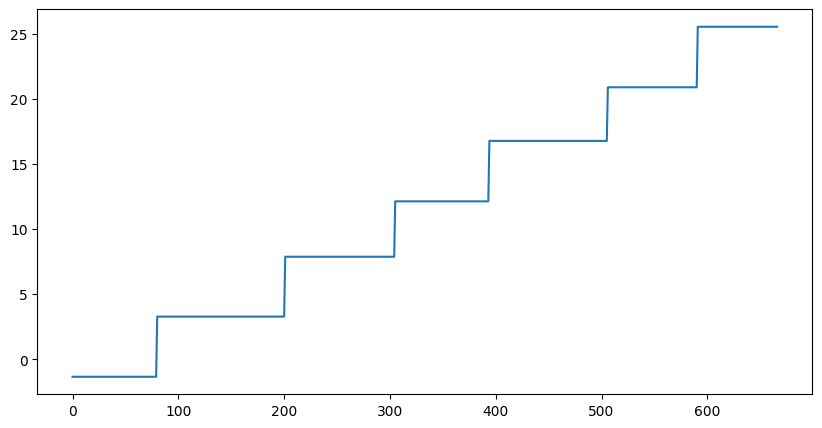

In [17]:
import matplotlib.pyplot as plt
offsets = np.array([l['alignment']/DOWNSAMPLE_SR - l['ts'] for l in lines])
plt.figure(figsize=(10,5))
plt.plot(offsets)
plt.show()

In [19]:
def convert_decimal_seconds_to_hh_mm_ss(timestamp):
    hours = int(timestamp / 3600)
    minutes = int((timestamp % 3600) / 60)
    seconds = int(timestamp % 60)
    return hours, minutes, seconds

dst_label_file = "fim_rainbow_roadtrip_auto.txt"
with open(dst_label_file, 'w', encoding='utf-8') as f:
    for l in lines:
        dur = l['te'] - l['ts']
        ts = l['alignment']/DOWNSAMPLE_SR
        te = ts + dur
        line = l['line'].split('_')
        #hh, mm, ss = convert_decimal_seconds_to_hh_mm_ss(ts)
        #line[0] = f"{hh:02d}"
        #line[1] = f"{mm:02d}"
        #line[2] = f"{ss:02d}"
        f.write(f"{ts}\t{te}\t{'_'.join(line)}")


In [30]:
# Update
import json
label_to_sig = {
    'fim_movie_auto.txt' : 'fim_movie',
    'fim_rainbow_roadtrip_auto.txt' : 'fim_rainbow roadtrip'
}
sig_file = 'extras_labels_index.json'

with open(sig_file, 'r', encoding='utf-8') as f2:
    obj = json.load(f2)
    for label_file,sig in label_to_sig.items():
        with open(label_file, 'r', encoding='utf-8') as f:
            lines = [{'ts': float(x[0]), 'te': float(x[1]), 'line': x[2].strip()} for x in [line.split('\t') for line in f.readlines()]]
        line_maps = {l['label'] : l for l in obj[sig]['lines']}

        for l in lines:
            if l['line'] not in line_maps:
                print("Skipping "+l['line'])
                continue
            line_maps[l['line']]['ts'] = l['ts']
            line_maps[l['line']]['te'] = l['te']
with open(sig_file, 'w', encoding='utf-8') as f2:
    json.dump(obj, f2)

Skipping 00_20_00_Mayor Sunny Skies_Happy Singingnging_Noisy_next-door neighbors chatting, over white wood fences, stopping on the street to say #hello#.
Skipping 00_20_08_Mayor Sunny Skies_Happy Singing_Noisy_when friends did well, we sang their praises, brought soup to comfort them when they felt #low#.
Skipping 00_20_16_Mayor Sunny Skies_Happy Singing_Noisy_that was our town at the end of the rainbow.
Skipping 00_20_25_Mayor Sunny Skies_Happy Singing_Very Noisy_no pots of gold, or buried treasure, just everypony looking after each #other#.
Skipping 00_20_33_Mayor Sunny Skies_Happy Singing_Very Noisy_the truest riches, cannot be measured, it was a lesson that had kept us #together#.
Skipping 00_20_41_Mayor Sunny Skies_Happy Singing_Noisy_in our town at the end of the #rainbow#.
Skipping 00_20_50_Mayor Sunny Skies_Happy Singing_Very Noisy_to honor our fine town my grandpa skies decided, to throw a party each and every #year#.
Skipping 00_21_10_Mayor Sunny Skies_Happy Singing_Very Nois

In [ ]:
# XXX: Everything below this line does not work. This was an attempt at using
# whisper_timestamped to generate timestamped transcriptions. This would be
# combined with fuzzy text searching to try to get an alignment
import whisper_timestamped as whisper
import os
import json

json_file_path = "transcription_result.json"

if os.path.exists(json_file_path):
    with open(json_file_path, "r") as json_file:
        result = json.load(json_file)
else:
    # audio = whisper.load_audio(r"D:\UnfuckPlugins\REAPER Media\Rainbow Roadtrip render 001.wav")
    audio = whisper.load_audio(r"D:\MLP_Samples\AIData\for vul\Rainbow Roadtrip.flac")
    model = whisper.load_model("medium")
    result = whisper.transcribe(model, audio, vad=True, language="en")
    # Problem: The VAD model does not think that Pinkie is actually speaking.
    with open(json_file_path, "w") as json_file:
        json.dump(result, json_file)

# So, the output is split into segments, but those segments do not necessarily align with our current transcription.
words = []
words_raw = []
for s in result["segments"]:
    for w in s["words"]:
        words.append(w)
        words_raw.append(w["text"].lower())
        
text_full = ' '.join(words_raw)


In [ ]:

print(json.dumps(result, indent = 2, ensure_ascii = False))

In [ ]:
# The next step is: We grab a transcription for a source, and we monotonically search for the index which most matches that.
src_label_file = r"D:\MLP_Samples\AIData\Master file\Sliced Dialogue\Label files\fim_rainbow roadtrip.txt"
with open(src_label_file, 'r', encoding='utf-8') as f:
    lines = [{'ts': x[0], 'te': x[1], 'line': x[2], 'startword': None} for x in [line.split('\t') for line in f.readlines()]]

from fuzzywuzzy import fuzz

start_idx = 0
MAX_JUMP = 200
PRE_WORD_ADJ = -.110 # sec adjustment of word beginning
import string
transl_table = str.maketrans('','',string.punctuation+string.whitespace)

for l in lines:
    # Wordwise alignment
    search_txt = l['line'].split('_')[-1]
    search_txt = search_txt.lower()
    search_words = search_txt.split()

    best_score = -1
    best_start = -1
    # TODO: We need to prevent long jumps. A jump over 200 cannot be accepted
    for j in range(start_idx,
        min(start_idx+MAX_JUMP, len(words_raw) - len(search_words) + 1)):
        test_txt = ' '.join(words_raw[j:j+len(search_words)]).replace('...','') # Ellipses screw things up
        score = fuzz.ratio(test_txt, search_txt)
        if score > best_score:
            best_score = score
            best_start = j
    # If the starting word is the same we can boost the score a little
    if words_raw[best_start].translate(transl_table).lower() == search_words[0].translate(transl_table).lower():
        best_score += 5

    # MAJOR problem: Timestamps seem to overflow past 3627

    l['startword'] = words[best_start]
    if best_score > 85:
        start_idx = best_start + max(len(search_words) - 2, 0)

    print(f"Score of {search_txt.strip()}: {best_score}")
    print(f"Not captured: {words[best_start]}")
    #if best_score < 85:
    #    print(f"Score of {search_txt.strip()}: {best_score}")
    #    print(f"Not captured: {words[best_start]}")

#capture_ratio = sum([1 if x['startword'] is not None else 0 for x in lines])/len(lines)
#print(f"Capture ratio: {capture_ratio}")

dst_label_file = "fim_rainbow_roadtrip_auto.txt"
with open(dst_label_file, 'w', encoding='utf-8') as f:
    for l in lines:
        f.write(f"{l['startword']['start'] + PRE_WORD_ADJ}\t{l['startword']['start'] + PRE_WORD_ADJ +(float(l['te']) - float(l['ts']))}\t{l['line']}")


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

# Cross-correlation based data realigner (doesn't work for our case)
SRC_AUDIO = r"D:\MLP_Samples\AIData\for vul\MLP Movie_C.flac"
#SRC_AUDIO = r"D:\MLP_Samples\AIData\for vul\Rainbow Roadtrip.flac"

# Operates off the assumption that audio clip order is invariant across
# different alignments.
# Also operates off the assumption that 2 seconds of clip is enough to identify it (?)

def find_alignment(src_audio = SRC_AUDIO):
    offset = 0
    src_data, src_sr = sf.read(src_audio, dtype='float32')
    src_8k = librosa.resample(src_data, orig_sr=48000, target_sr=8000)

    clip = r"D:\MEGASyncDownloads\Master file 2\MLP Movie (still has music, don't use this in any training)\MLP Movie\00_01_28_Rachel Platten_Singing_Noisy_hey! hey! hey!.flac"
    #clip = r"D:\MLP_Samples\AIData\Master file\Sliced Dialogue\FiM\Rainbow Roadtrip\00_00_40_Pinkie_Neutral_Noisy_Okay, not technically a road trip because we're taking that..flac"
    #clip = r"D:\MLP_Samples\AIData\Master file\Sliced Dialogue\FiM\Rainbow Roadtrip\00_05_00_Applejack_Happy_Very Noisy_Huh. now that sounds right up my river..flac"
    clip_data, clip_sr = sf.read(clip, dtype='float32')

    # 0. Both clips begin at a sample rate of 48khz
    assert src_sr == 48000
    assert clip_sr == 48000

    # 1. To get a "coarse" alignment, we downsample both clips to 8khz (which is
    # enough to convey speech data). If there is an error of 1 sample then that is .000125 sec which is acceptable
    clip_8k = librosa.resample(clip_data, orig_sr=48000, target_sr=8000)

    # Limit the clip to 1 second for identification purposes
    #clip_8k = clip_8k[:32000]
    clip_8k = clip_8k[:16000]

    # 2. Calculate cross correlation with a sliding window 
    #traversal = len(src_8k) - len(clip_8k) + 1
    #cross_corr = np.zeros(traversal)
    #print(traversal)
    #for i in tqdm(range(traversal)):
    #    cross_corr[i] = np.dot(src_8k[i:i+len(clip_8k)], clip_8k)

    # 2. Calculate cross-correlation using FFT method
    result_length = len(src_8k) + len(clip_8k) - 1
    fft_src = np.fft.fft(src_8k, n=result_length)
    fft_clip = np.fft.fft(clip_8k, n=result_length)
    cross_corr = np.fft.ifft(fft_src * np.conj(fft_clip)).real

    # 3. Plot cross correlation to get reasonable preliminary coefficient values.
    plt.figure(figsize=(10, 5))
    plt.plot(cross_corr)
    plt.title('Cross-correlation between audio1 and audio2')
    plt.xlabel('Sample shift')
    plt.ylabel('Cross-correlation')
    plt.grid(True)
    plt.show()

    # at 8khz, the 8000th sample corresponds to the 48000th sample.
    # Multiply by 6 to get the offset.

find_alignment()